In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
import main
from main import RNNLayer
import ast
import DSA
import copy
from notebooks.utils_mamba import *
%load_ext autoreload
%autoreload 2

### Load config

In [2]:
config = load_config("../config.yaml")
taskset = "PDM"

### Get dissimilarities

#### Computation dynamics

In [3]:
df = get_dataframe(taskset)

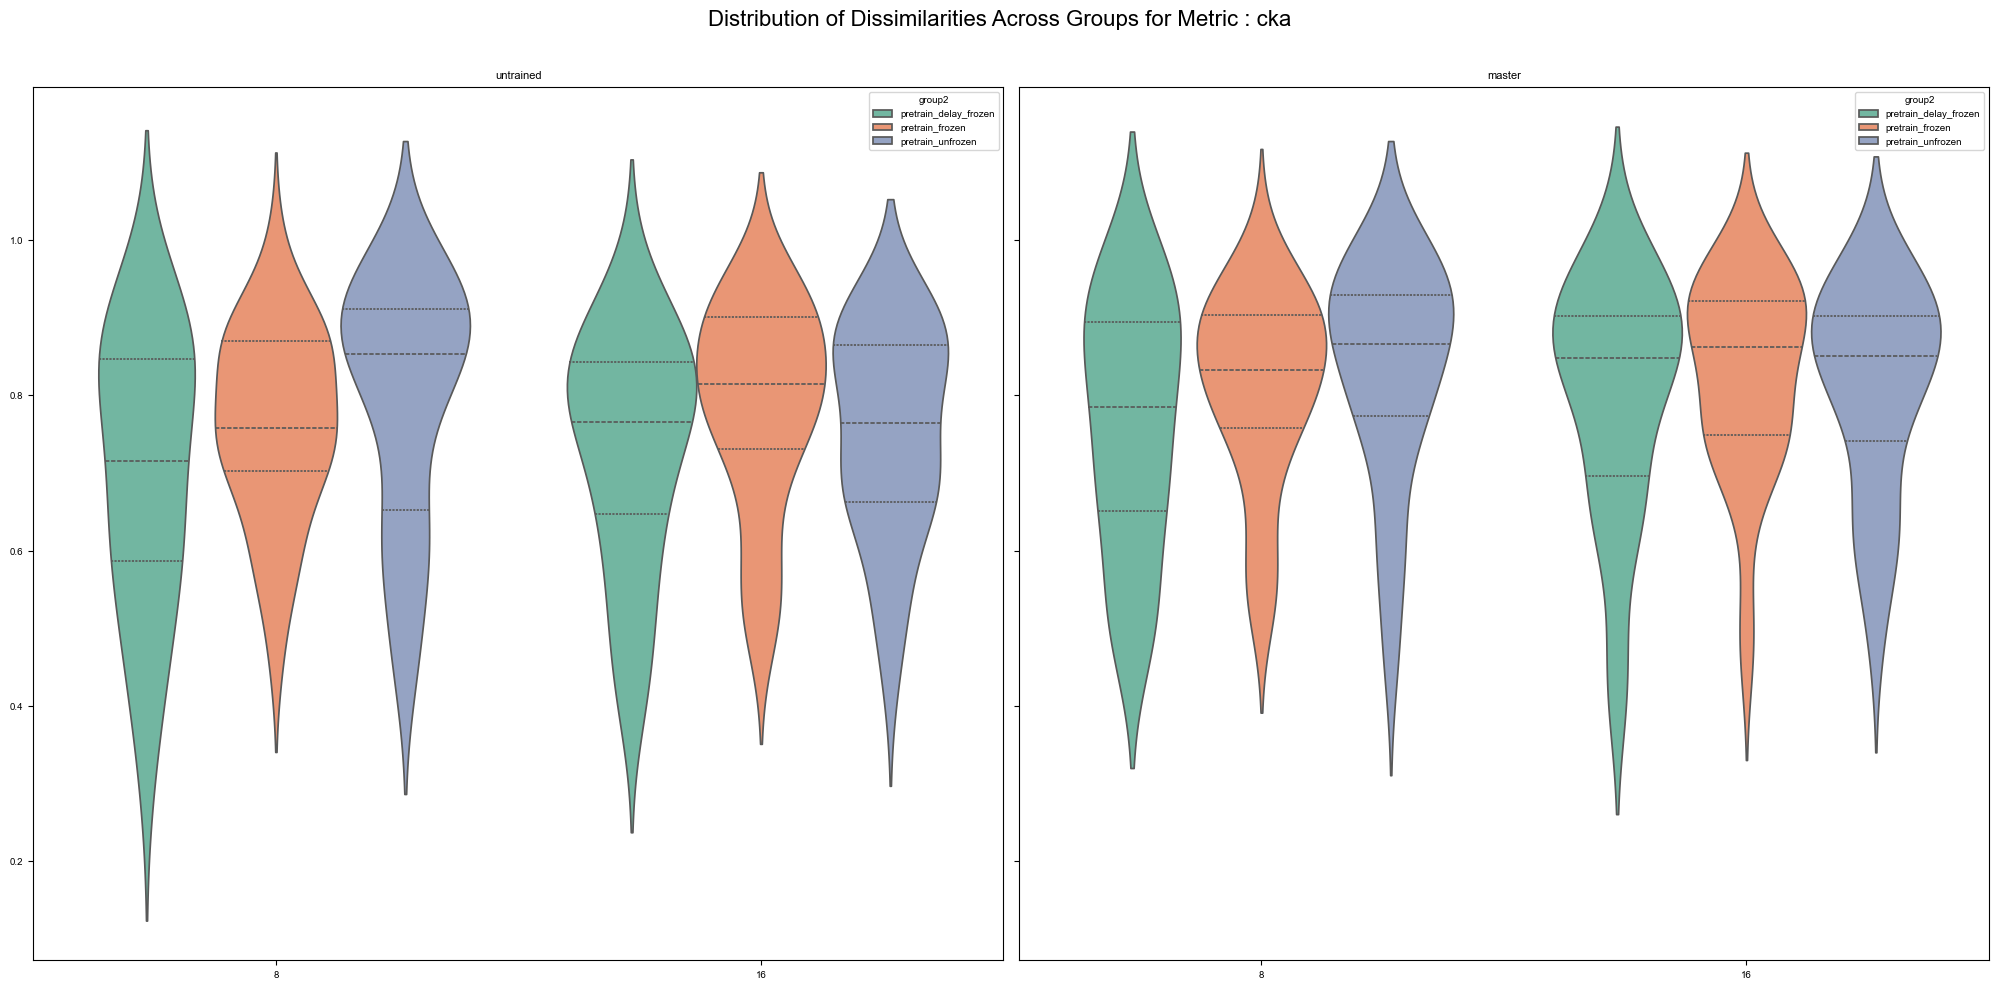

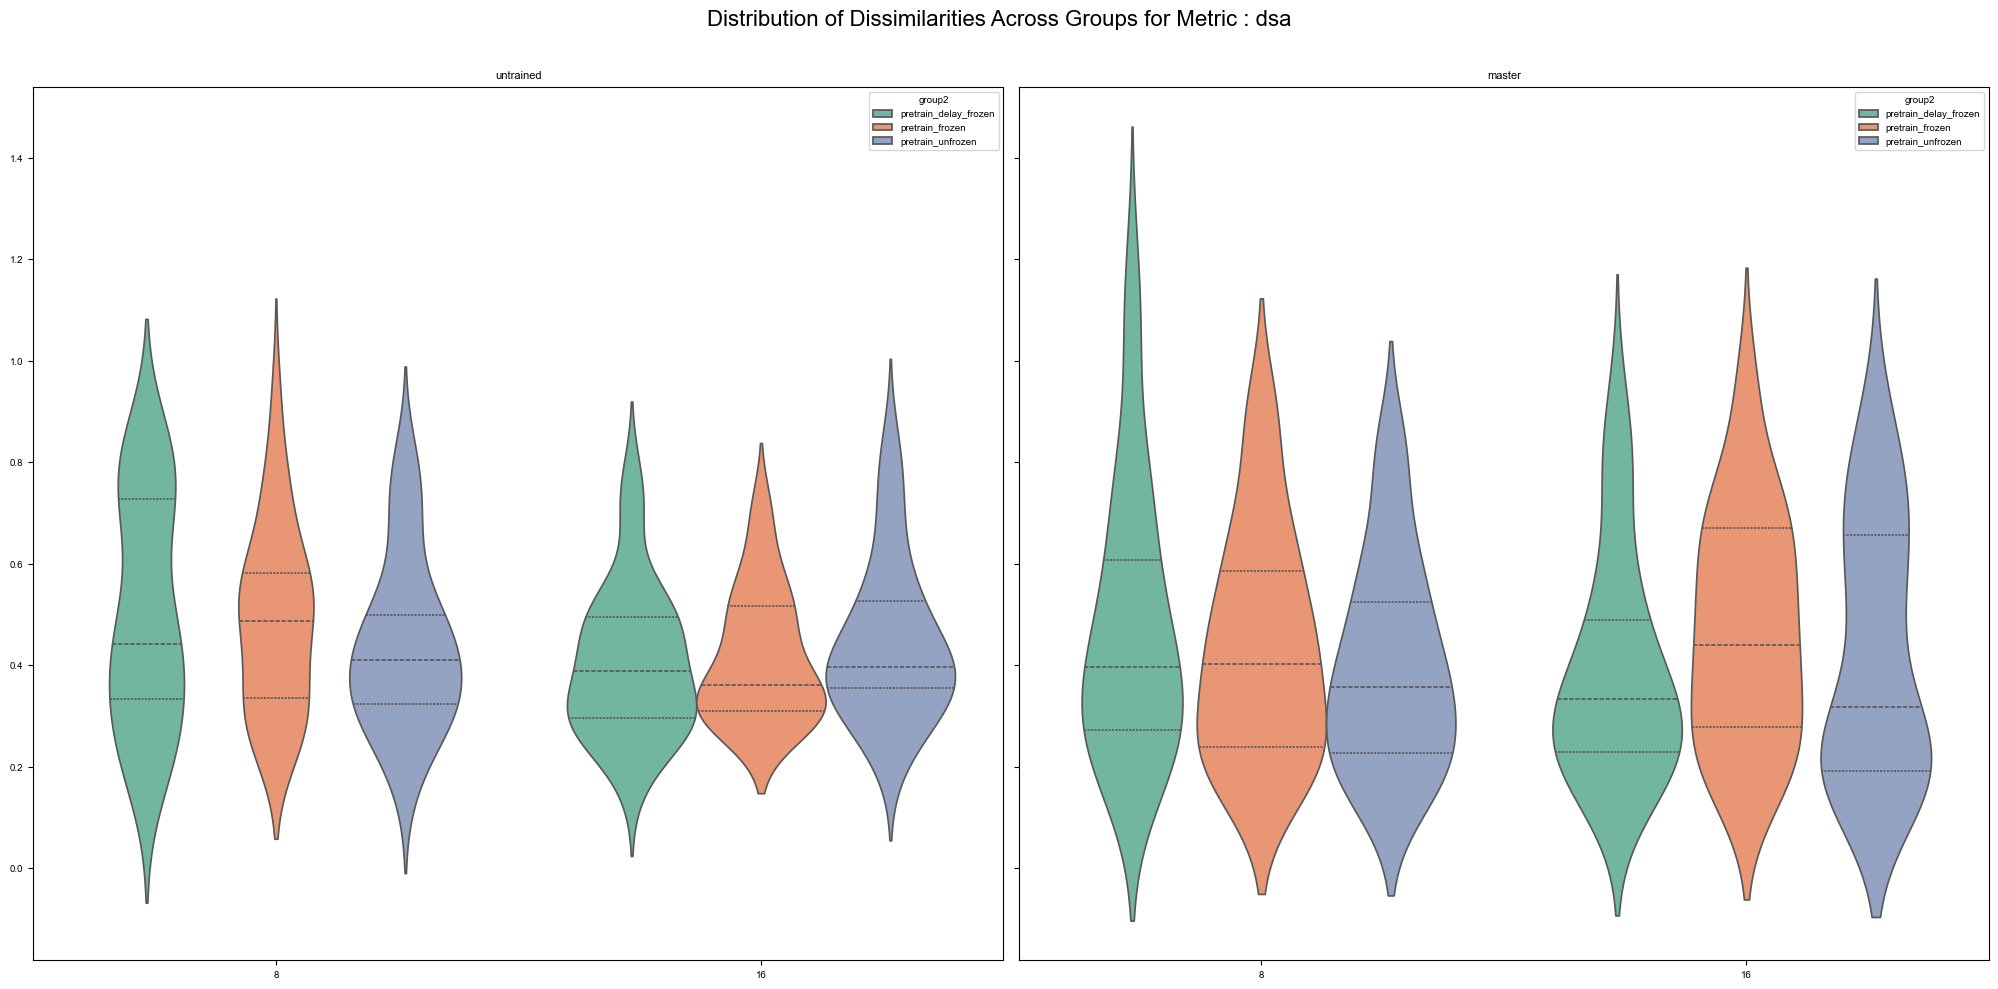

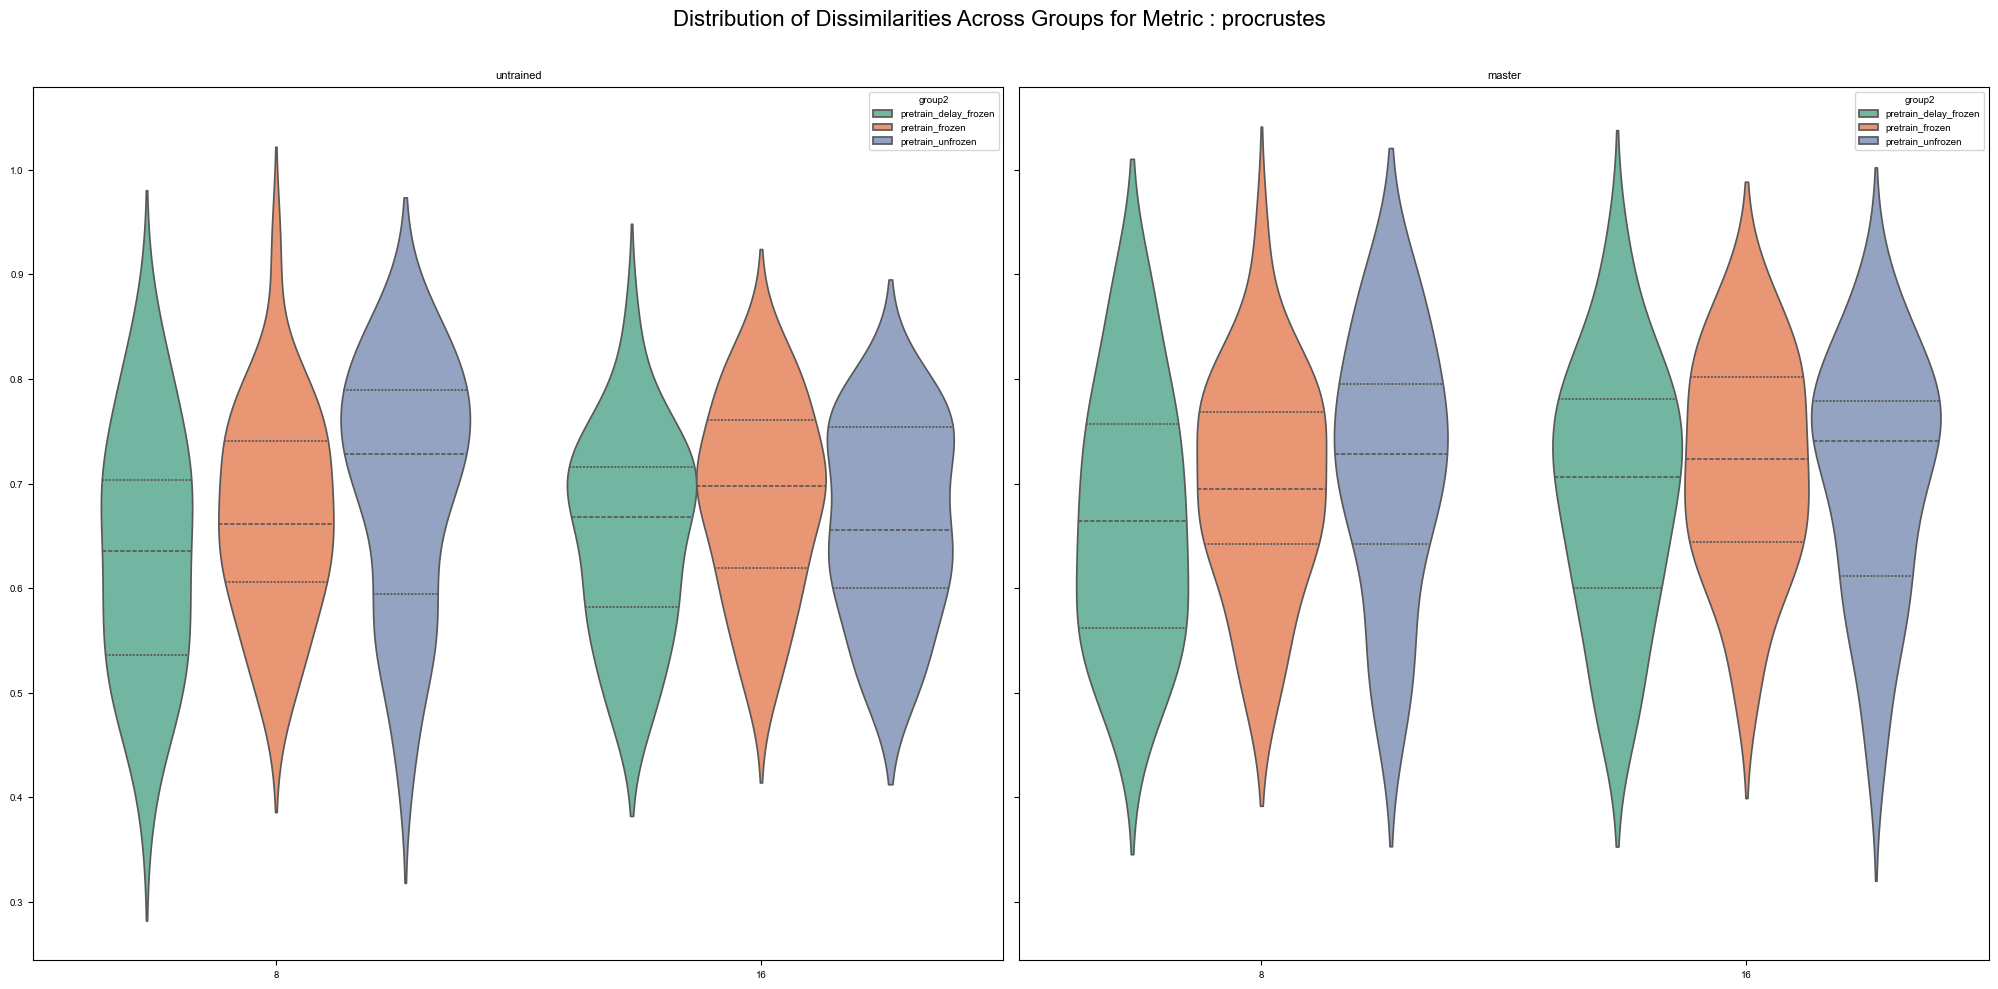

In [4]:
from math import log
groups_base = ["untrained", "master"]
groups_selected = ["pretrain_delay_frozen", "pretrain_frozen", "pretrain_unfrozen"]
df_selected = df[df["group1"].isin(groups_base) & df["group2"].isin(groups_selected)]
for measure in ["cka", "dsa","procrustes"]:
    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(20, 10), sharex=True, sharey=True
    )

    # Iterate over each group pair
    for group in groups_base:
        ax = axes[groups_base.index(group)]
        # Plot a violin plot for the dissimilarity distribution
        sns.violinplot(
            data=df_selected[
                (df_selected["group1"] == group) &
                (df_selected["measure"] == measure)
            ],
            x="d_model",
            y="dissimilarity",
            hue="group2",
            ax=ax,
            inner="quart",
            palette="Set2",
        )
        ax.set_title(f"{group}", fontsize=8)
        ax.set_xlabel("")
        ax.set_ylabel("")

    # Adjust layout
    plt.suptitle(
        f"Distribution of Dissimilarities Across Groups for Metric : {measure}",
        fontsize=16,
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

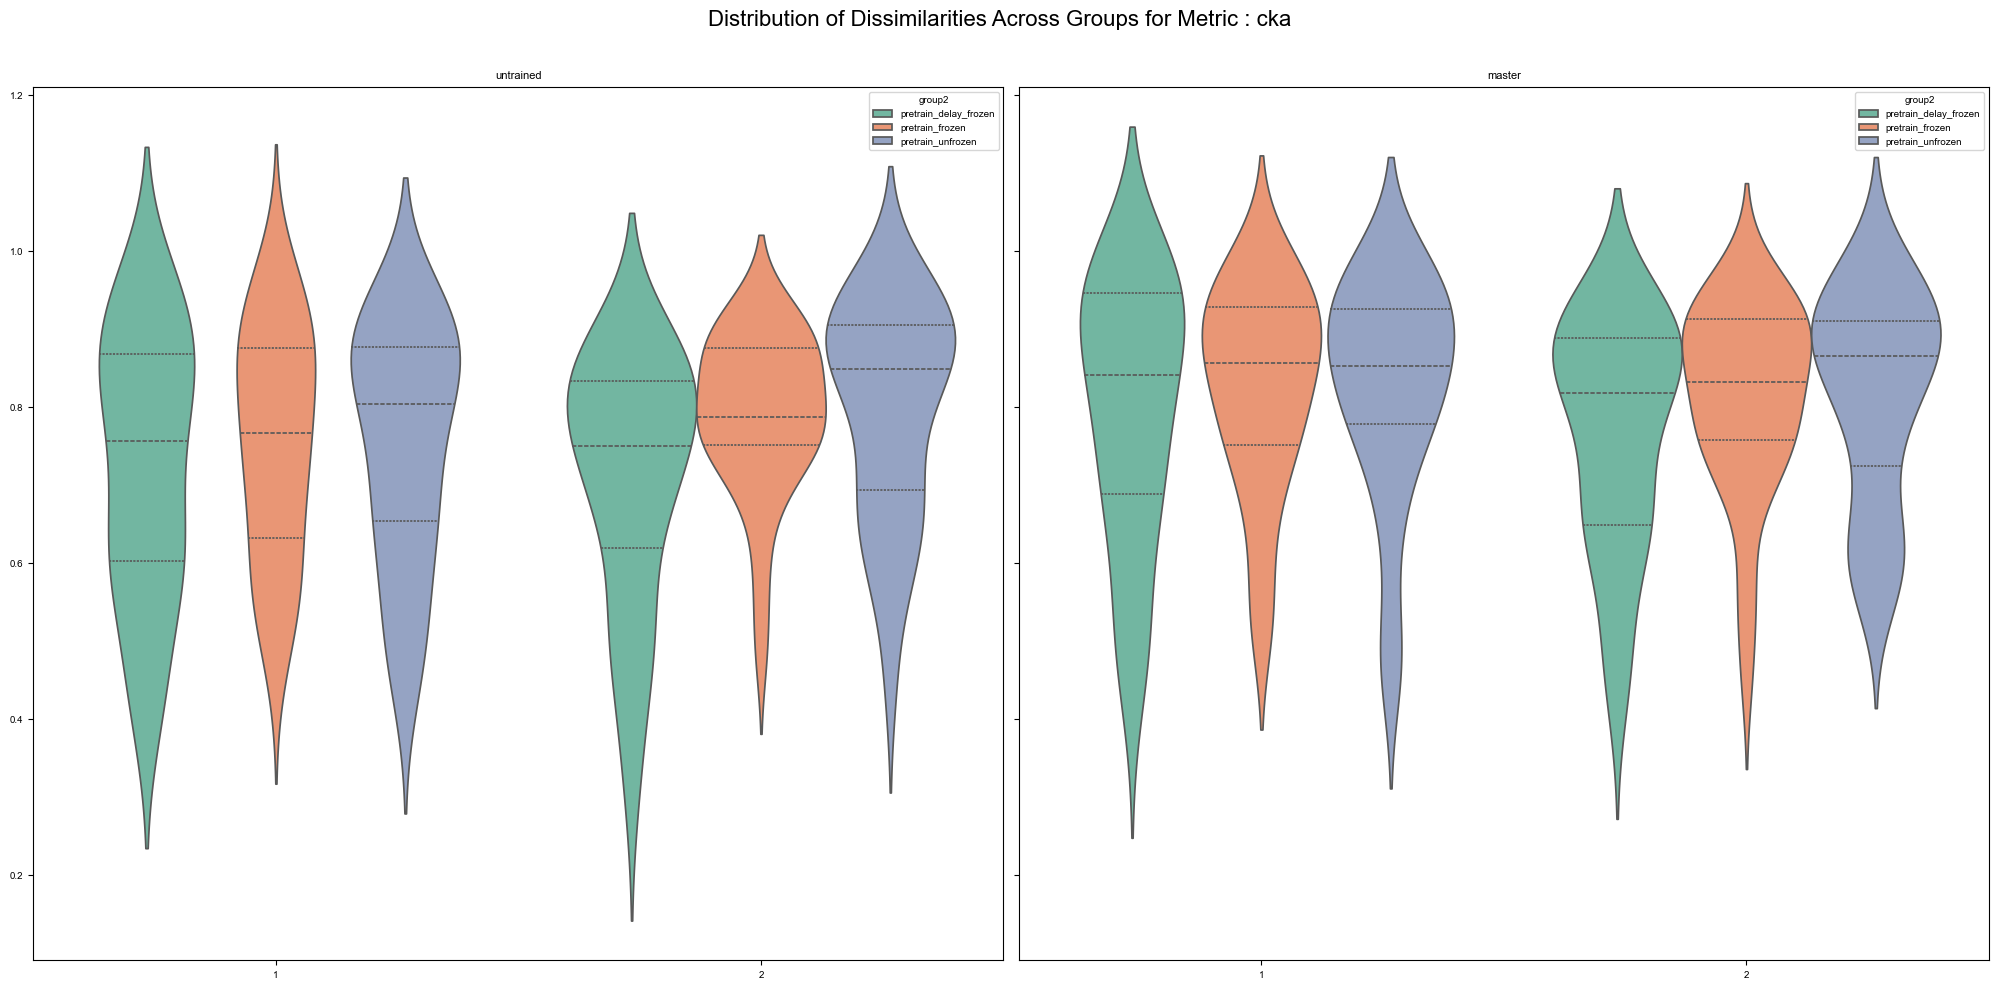

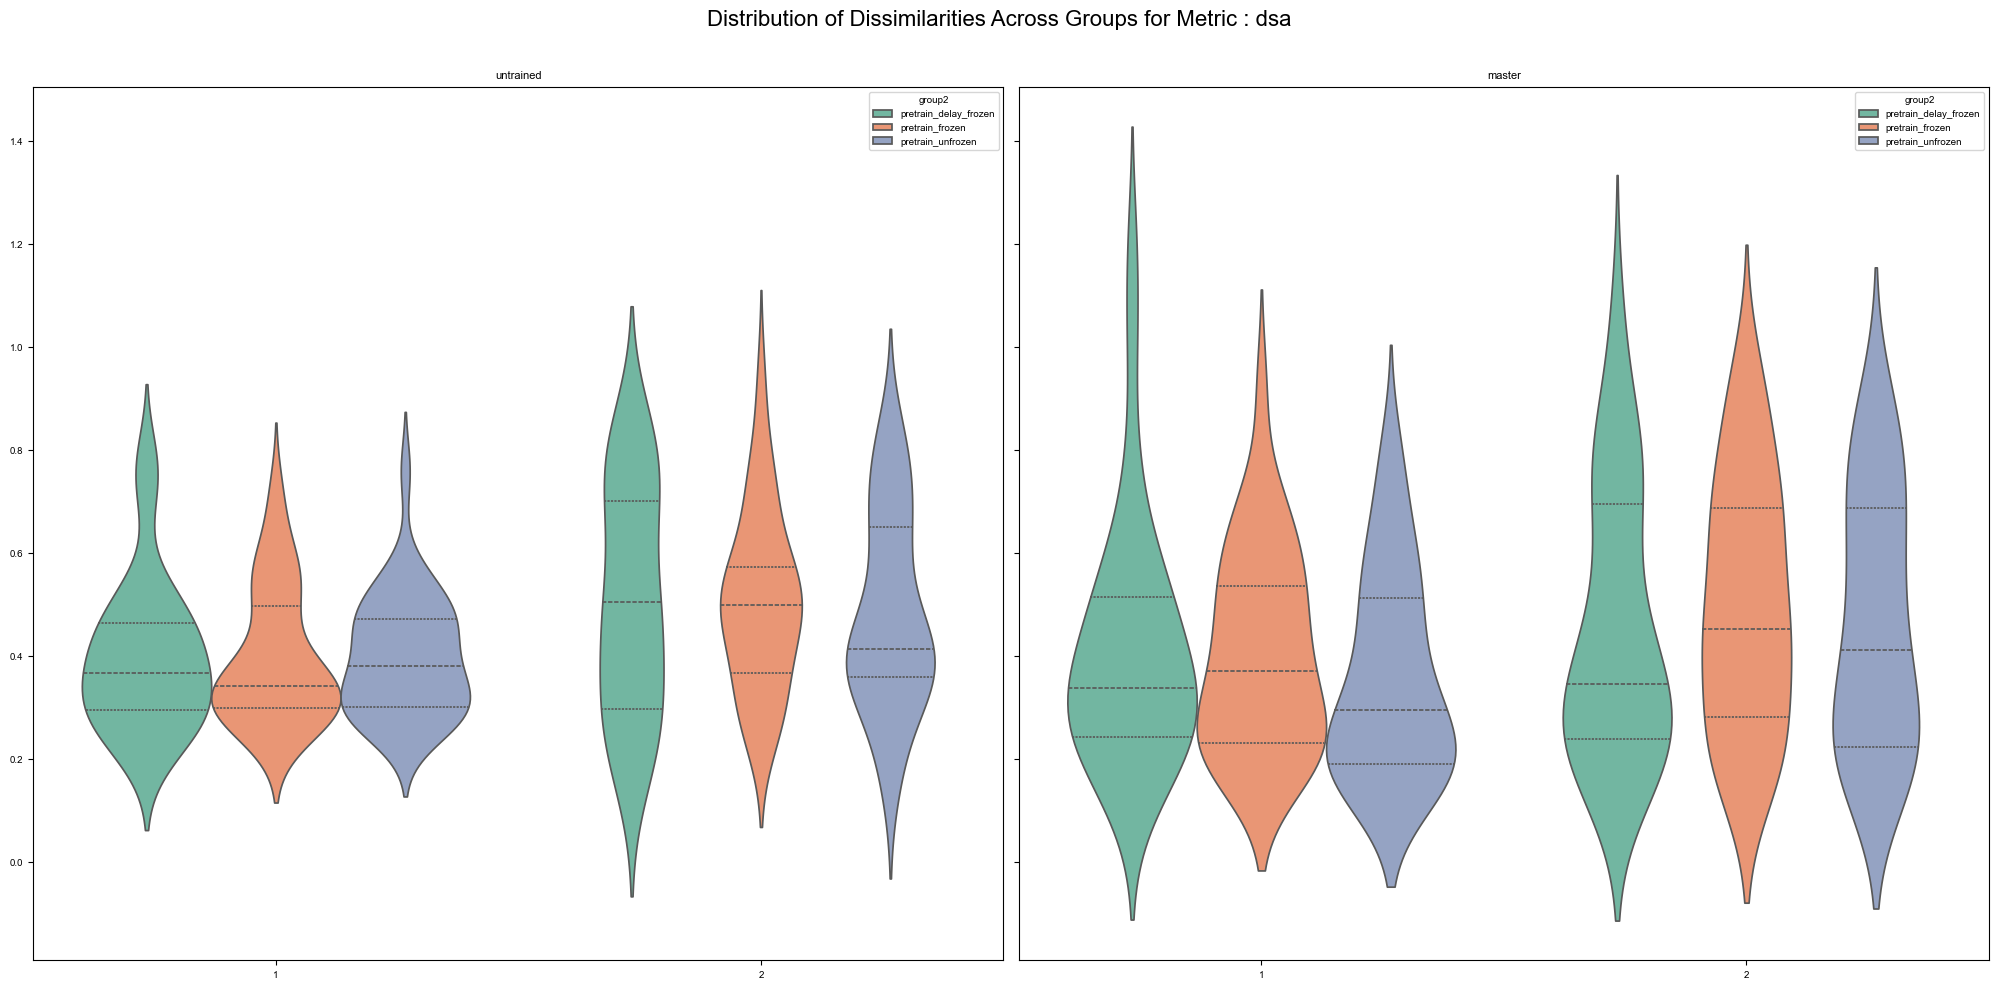

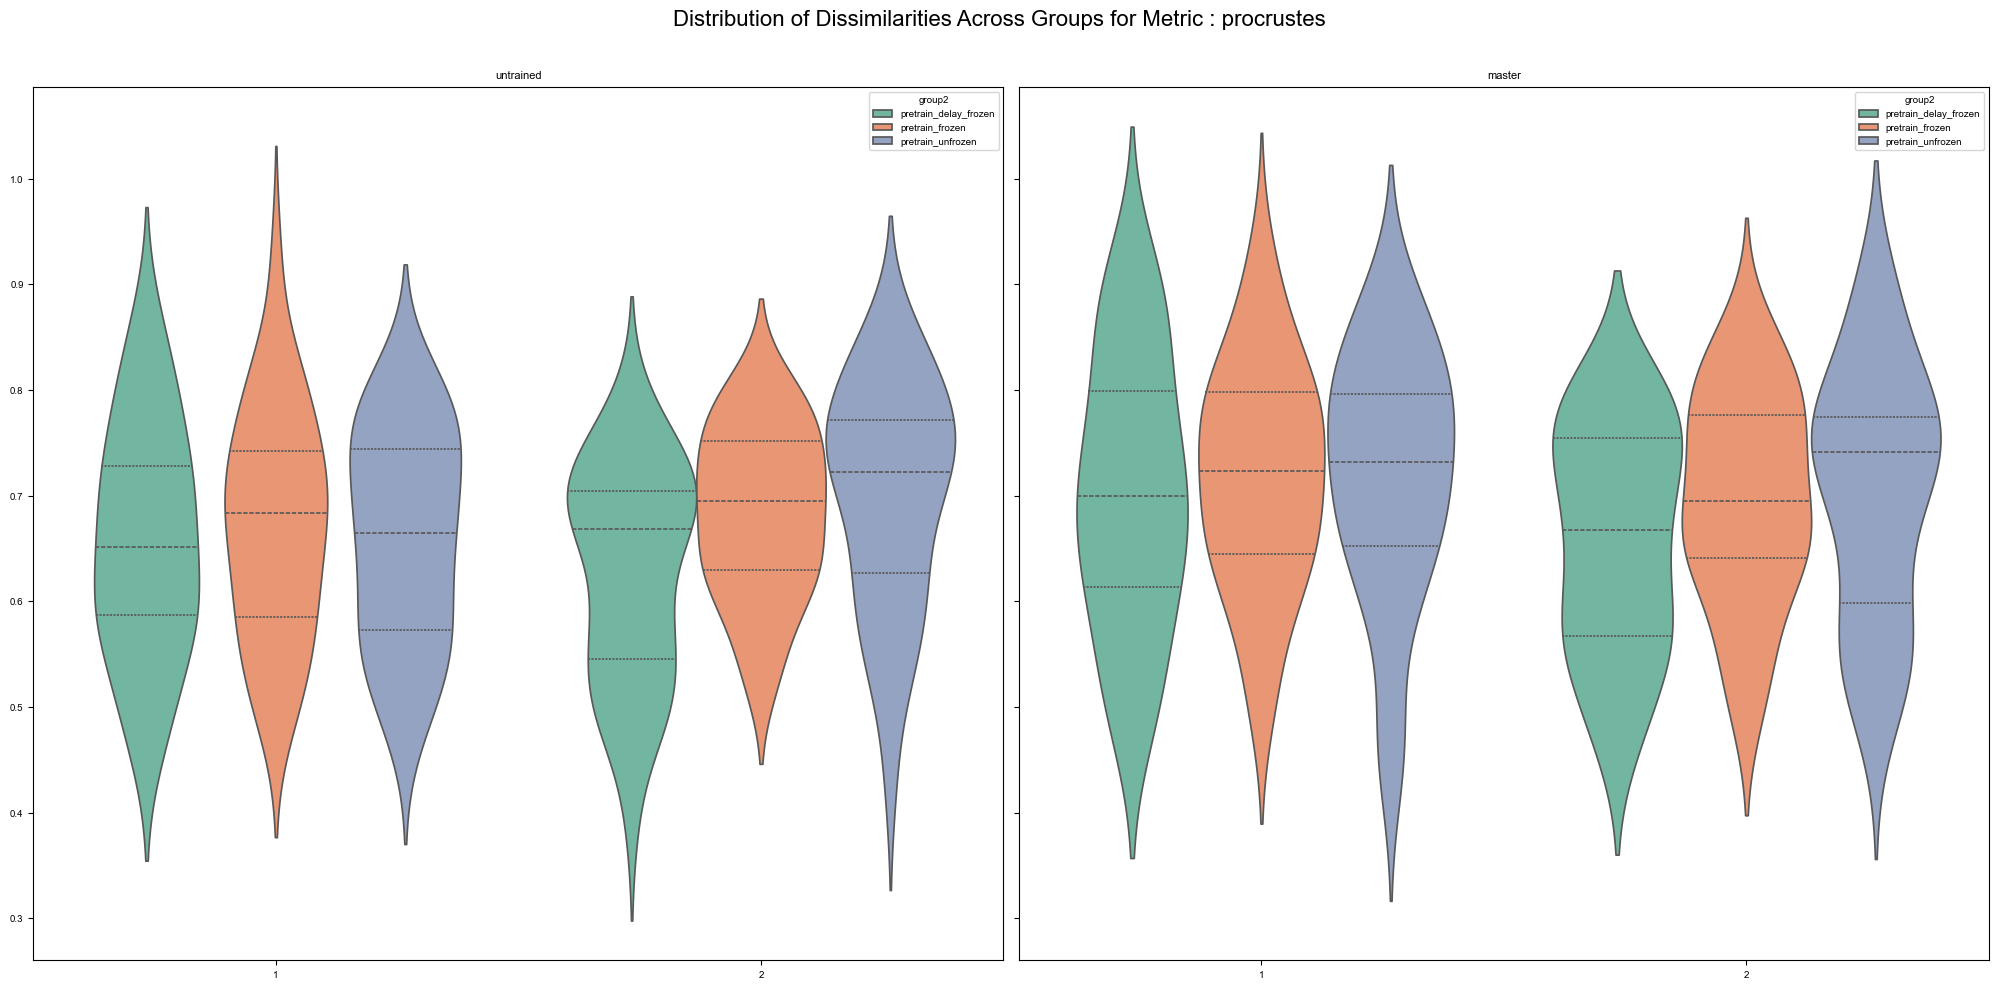

In [5]:
from math import log

groups_base = ["untrained", "master"]
groups_selected = ["pretrain_delay_frozen", "pretrain_frozen", "pretrain_unfrozen"]
df_selected = df[df["group1"].isin(groups_base) & df["group2"].isin(groups_selected)]
for measure in ["cka", "dsa", "procrustes"]:
    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(20, 10), sharex=True, sharey=True
    )

    # Iterate over each group pair
    for group in groups_base:
        ax = axes[groups_base.index(group)]
        # Plot a violin plot for the dissimilarity distribution
        sns.violinplot(
            data=df_selected[
                (df_selected["group1"] == group) & (df_selected["measure"] == measure)
            ],
            x="n_layers",
            y="dissimilarity",
            hue="group2",
            ax=ax,
            inner="quart",
            palette="Set2",
        )
        ax.set_title(f"{group}", fontsize=8)
        ax.set_xlabel("")
        ax.set_ylabel("")

    # Adjust layout
    plt.suptitle(
        f"Distribution of Dissimilarities Across Groups for Metric : {measure}",
        fontsize=16,
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [6]:
# df_selected = df[(df["n_layers"]==1) & (df["d_model"]==8)]
df_selected = df

In [7]:
# Group by 'group1', 'group2', and 'measure', then calculate median dissimilarities
median_dissimilarities = (
    df_selected.groupby(["group1", "group2", "measure"])["dissimilarity"].median().reset_index()
)

# Pivot the data to prepare it for the heatmap
pivot_table = median_dissimilarities.pivot_table(
    index="group1", columns="group2", values="dissimilarity"
)

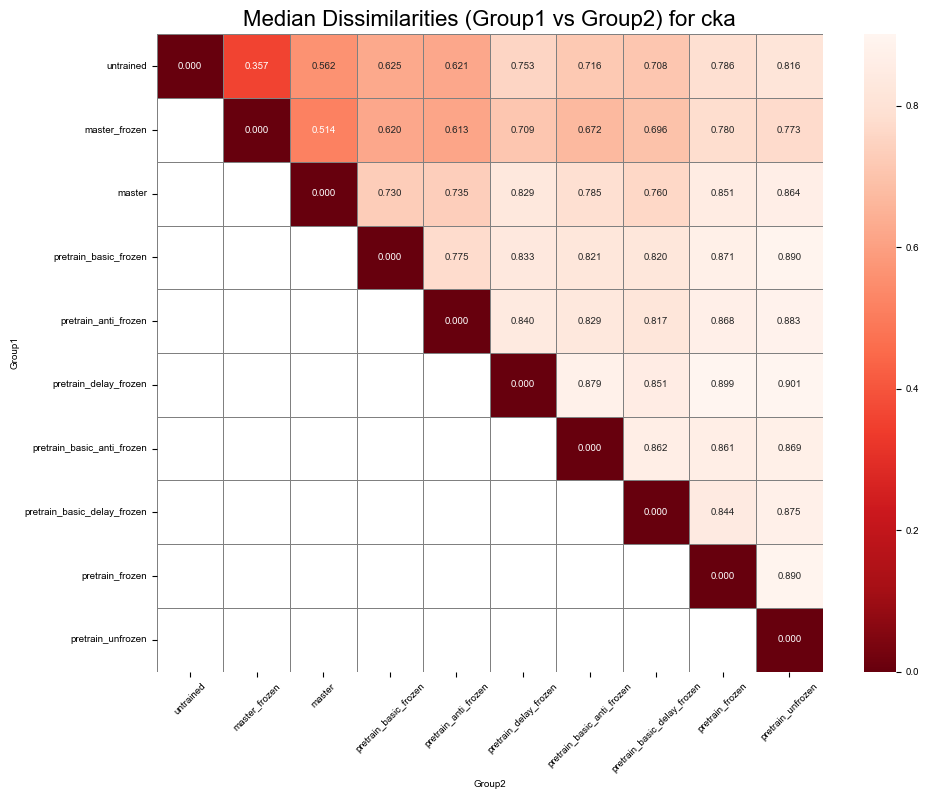

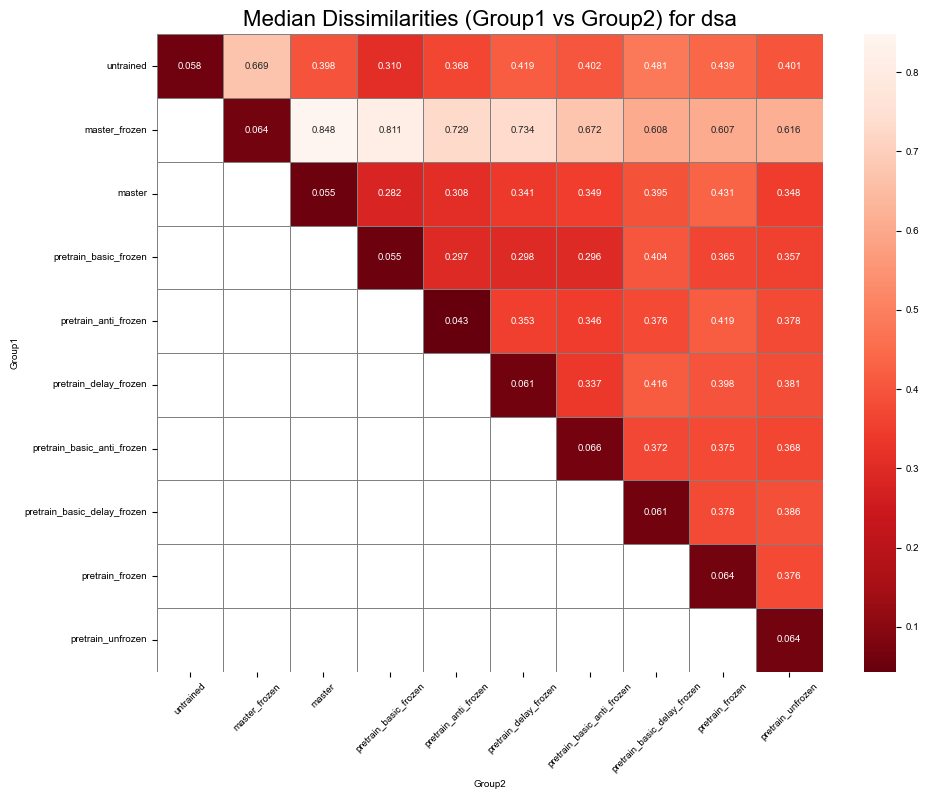

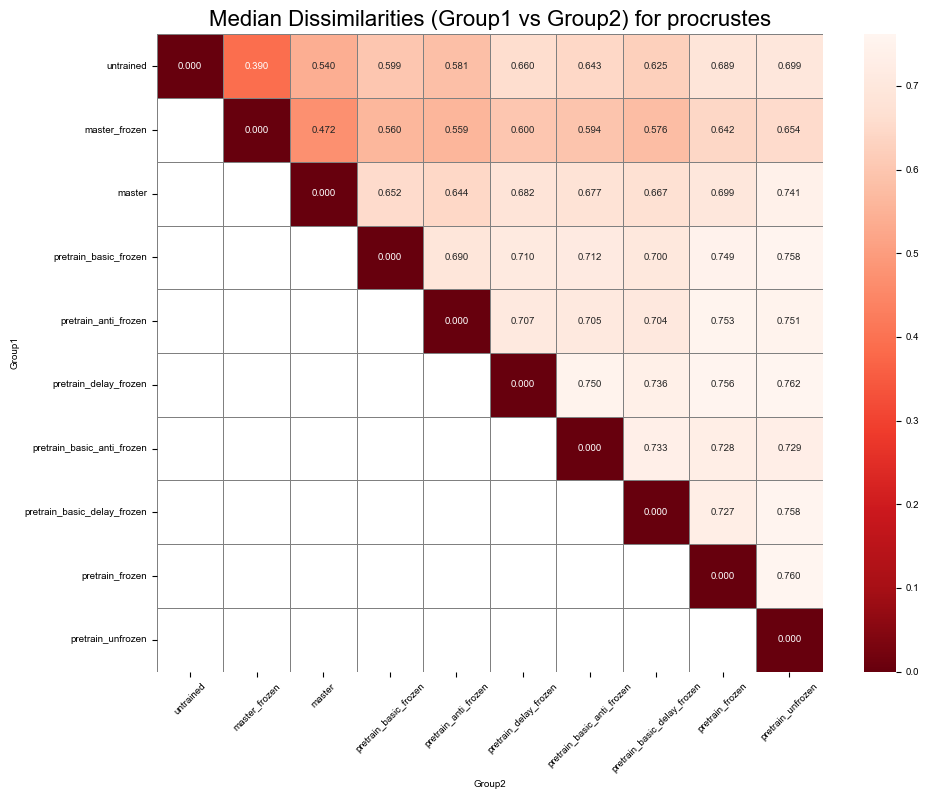

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming median_dissimilarities DataFrame is defined

# Define the desired order for groups
groups = [
    "untrained",
    "master_frozen",
    "master",
    "pretrain_basic_frozen",
    "pretrain_anti_frozen",
    "pretrain_delay_frozen",
    "pretrain_basic_anti_frozen",
    "pretrain_basic_delay_frozen",
    "pretrain_frozen",
    "pretrain_unfrozen",
]

# Unique measures
measures = df["measure"].unique()

# Plot heatmap for each measure
for measure in measures:
    # Filter the pivot table for the specific measure
    measure_pivot = median_dissimilarities[
        median_dissimilarities["measure"] == measure
    ].pivot(index="group1", columns="group2", values="dissimilarity")

    # Reorder the rows and columns according to the specified groups
    measure_pivot = measure_pivot.reindex(index=groups, columns=groups)

    # Create a mask for the lower triangle (excluding the diagonal)
    mask = np.tril(np.ones_like(measure_pivot, dtype=bool), -1)

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        measure_pivot,
        annot=True,
        fmt=".3f",
        cmap="Reds_r",
        cbar=True,
        linewidths=0.5,
        linecolor="gray",
        mask=mask,  # Apply the mask to show only the upper triangle including the diagonal
    )
    plt.title(f"Median Dissimilarities (Group1 vs Group2) for {measure}", fontsize=16)
    plt.xlabel("Group2")
    plt.ylabel("Group1")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [9]:
group_pairs = find_group_pairs(config, taskset)

In [10]:
dissimilarities_per_shared_task = dissimilarities_per_percentage_of_shared_task(group_pairs, df)

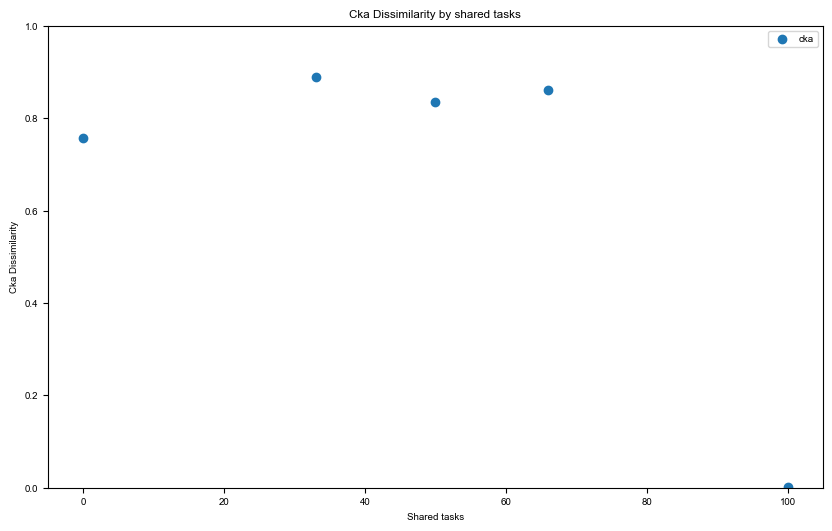

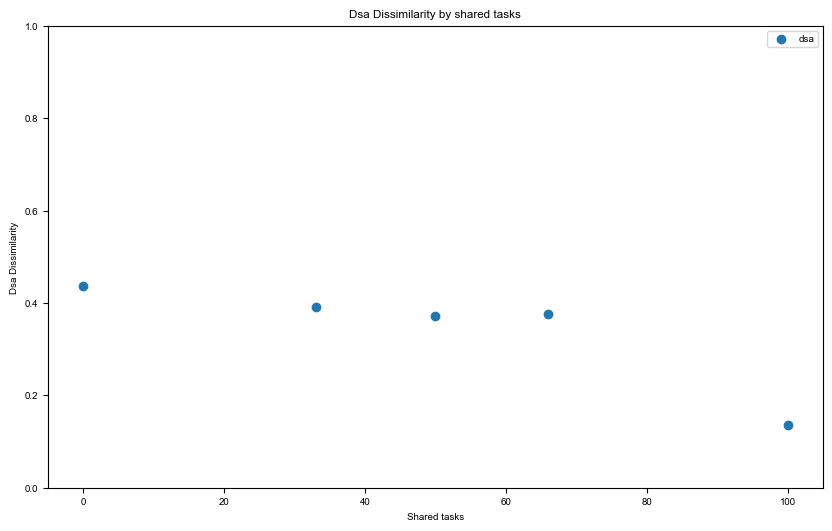

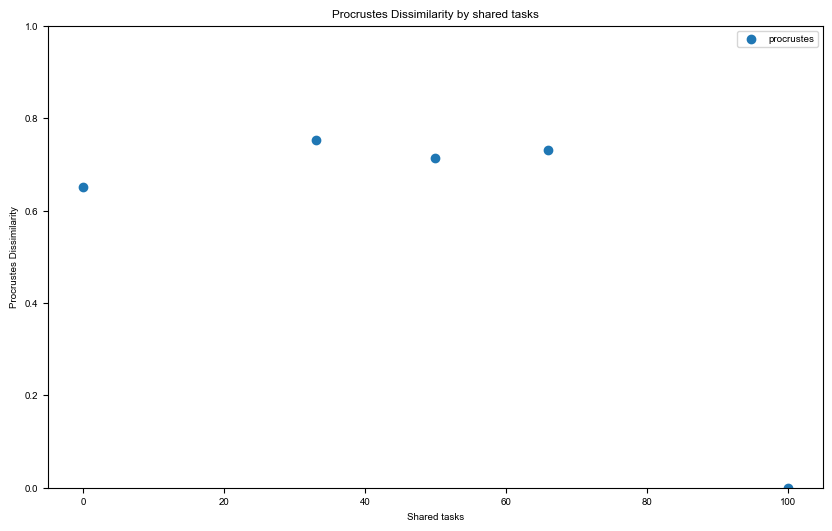

In [11]:
# plot the dissimilarities per shared task by taking median of the dissimilarities for each shared task. shared task as x-axis and dissimilarity as y-axis and do a line plot without errors
for measure in ["cka", "dsa", "procrustes"]:
    dissimilarities_per_shared_task[measure] = {
        k: np.median(v) for k, v in dissimilarities_per_shared_task[measure].items()
    }
    percent_shared_tasks_sorted = sorted(
        list(dissimilarities_per_shared_task[measure].keys())
    )
    dissimilarities = [dissimilarities_per_shared_task[measure][percent] for percent in percent_shared_tasks_sorted]
    plt.figure(figsize=(10, 6))
    plt.scatter(
        percent_shared_tasks_sorted,
        dissimilarities,
        label=measure,
    )
    plt.xlabel("Shared tasks")
    plt.ylim(0, 1)
    plt.ylabel(f"{measure.capitalize()} Dissimilarity")
    plt.title(f"{measure.capitalize()} Dissimilarity by shared tasks")
    plt.legend()
    plt.show()    

#### Learning dynamics

For now, only analysis for pretrain_frozen against pretrain_unfrozen

In [12]:
dissimilarities_groups, groups_training = get_dissimilarities_groups(taskset)

/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/repal-8PB6Q6y1-py3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/repal-8PB6Q6y1-py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


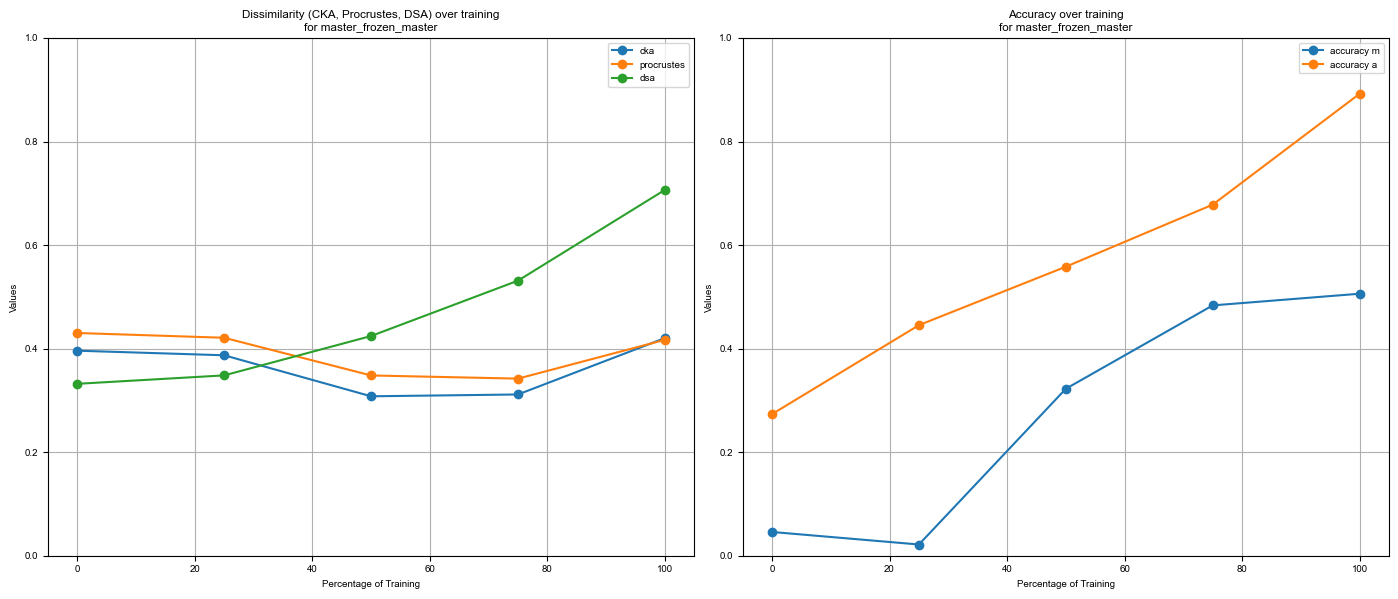

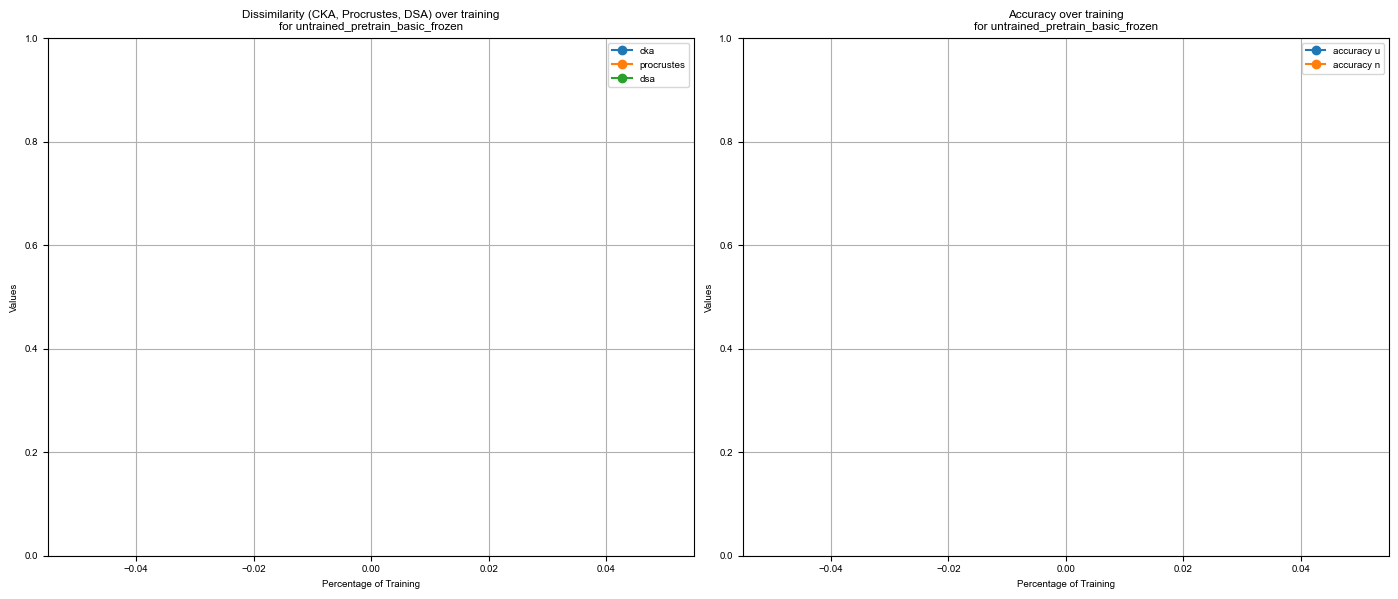

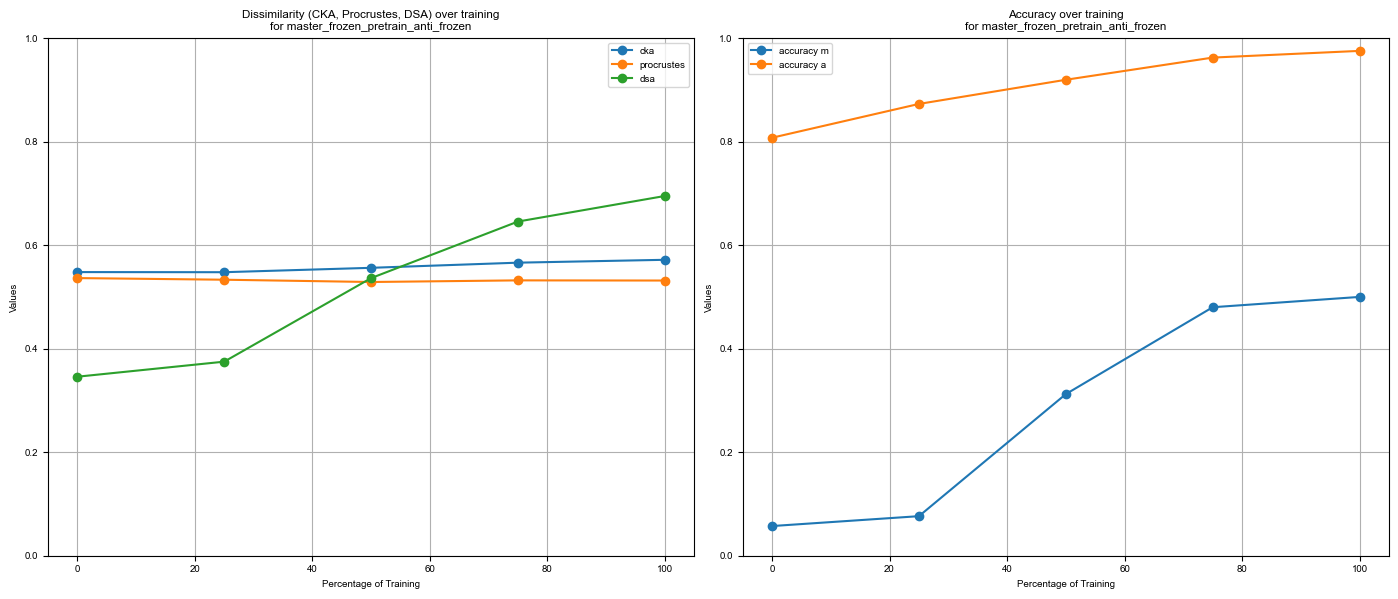

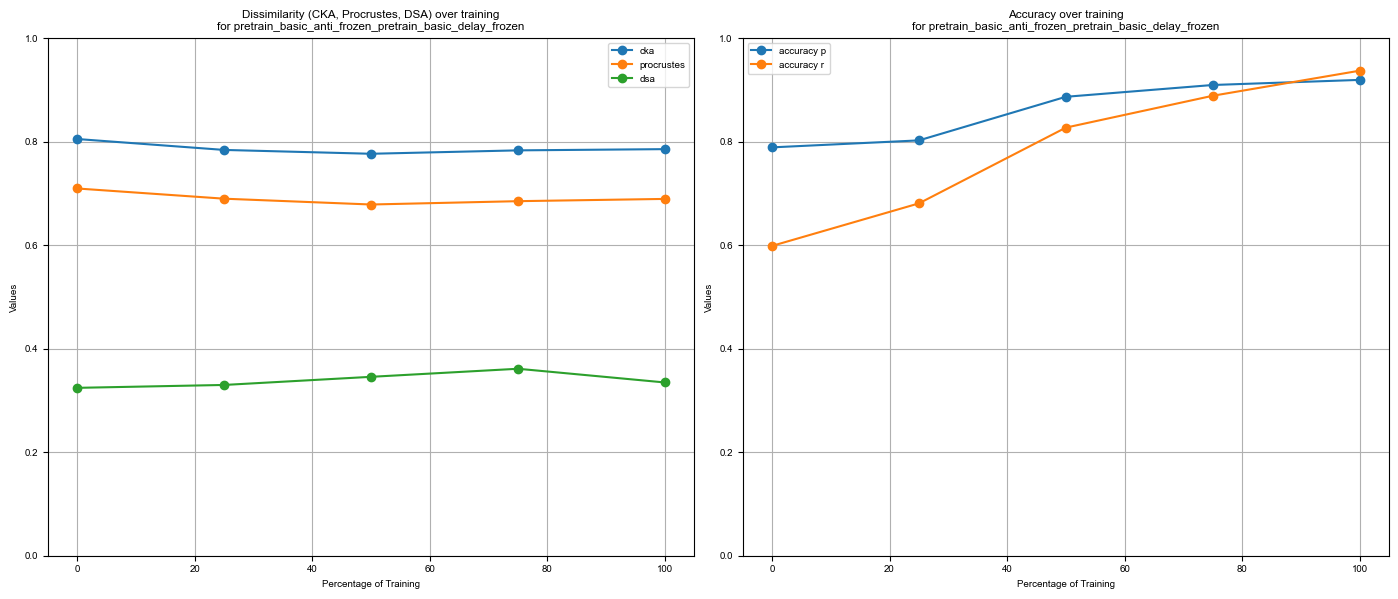

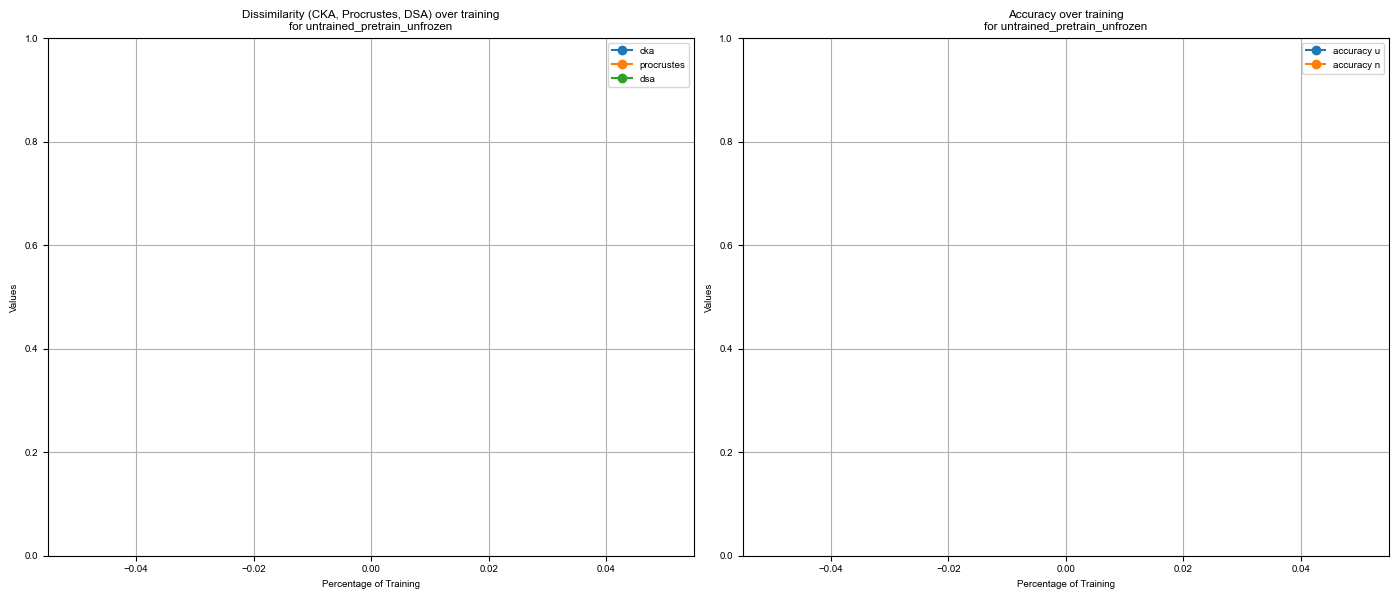

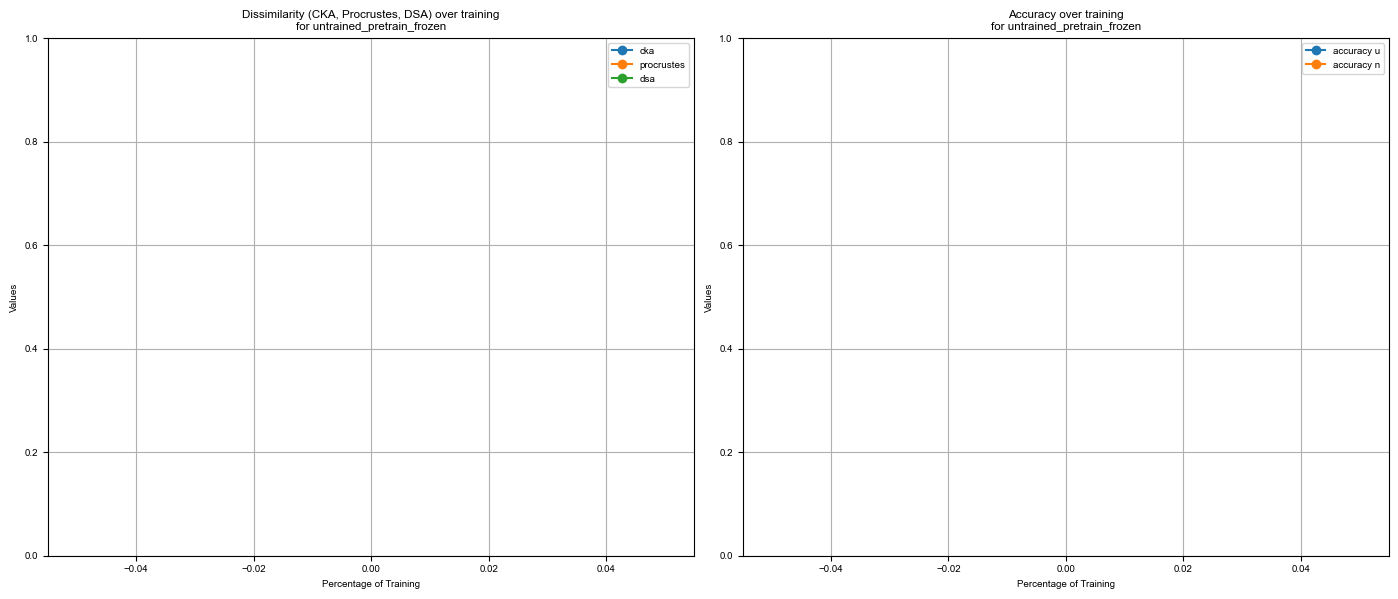

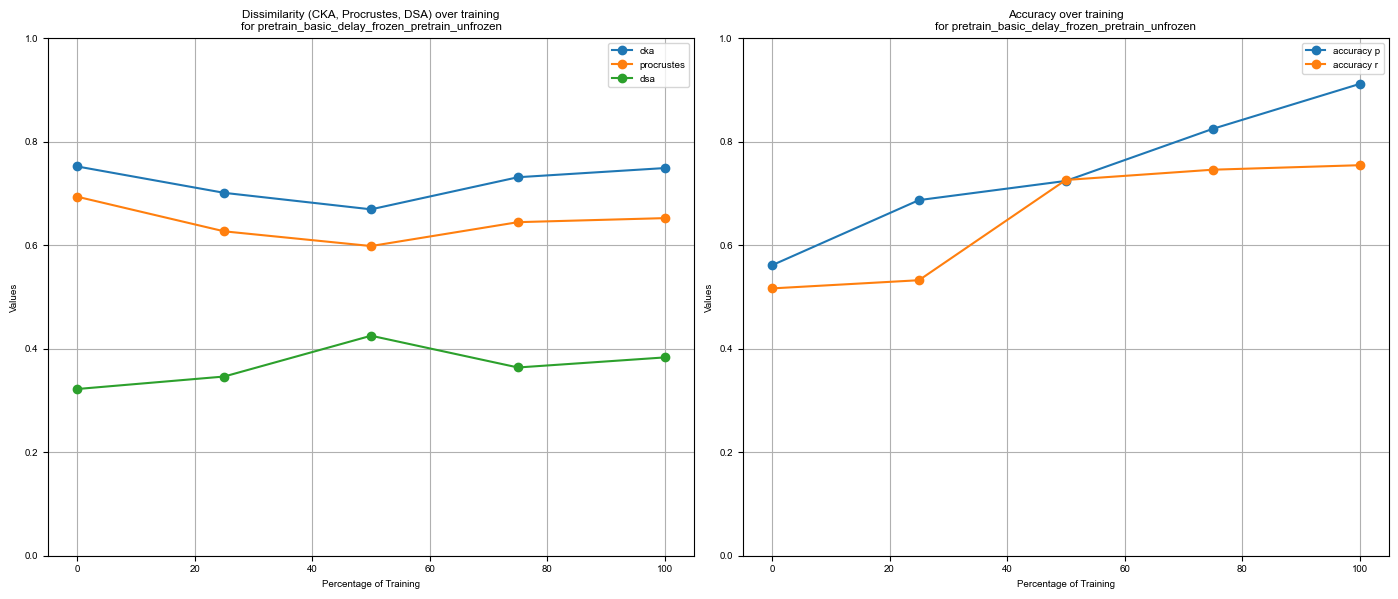

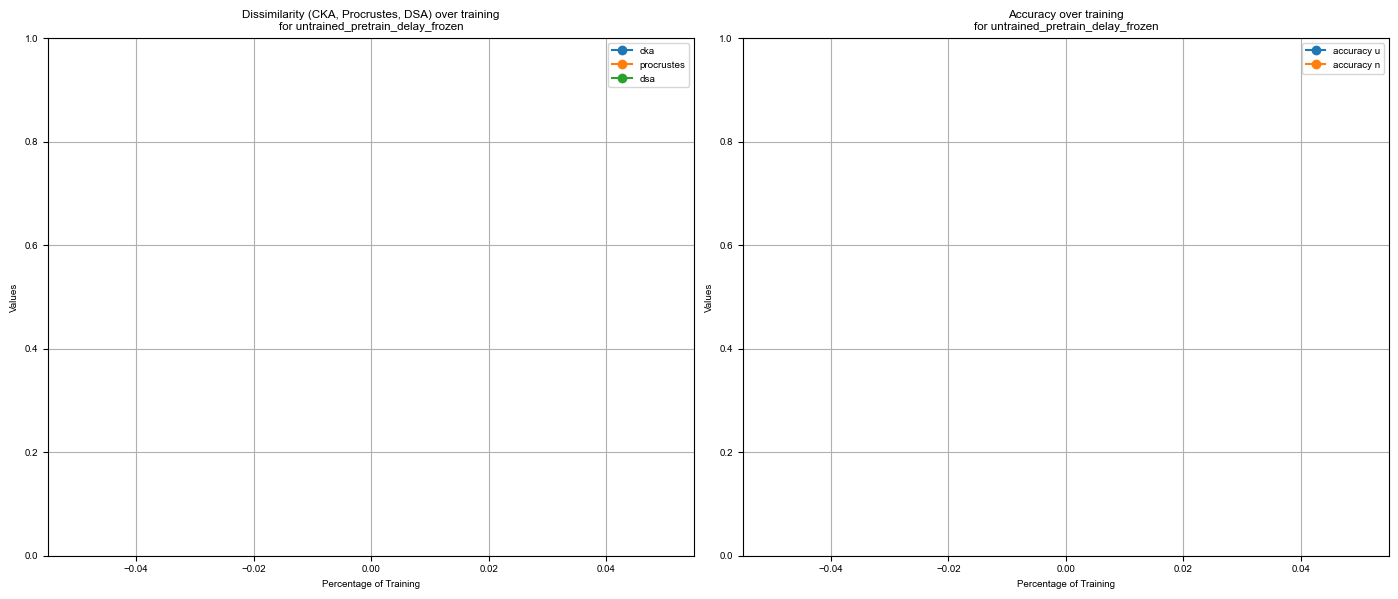

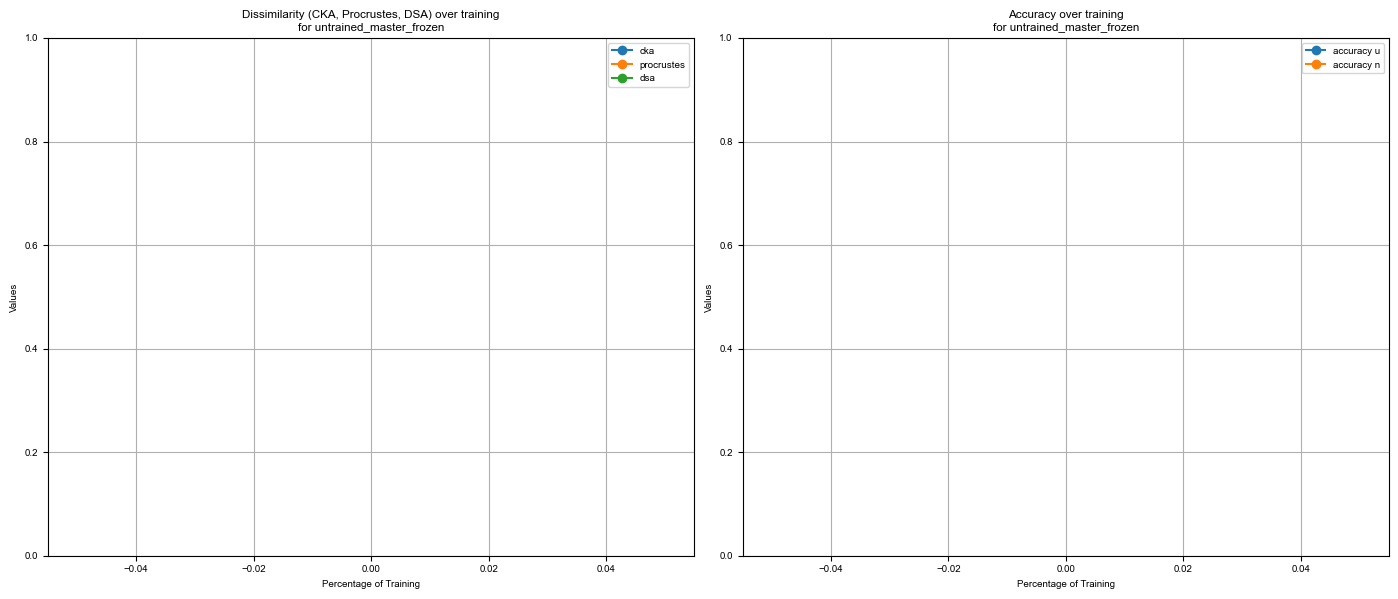

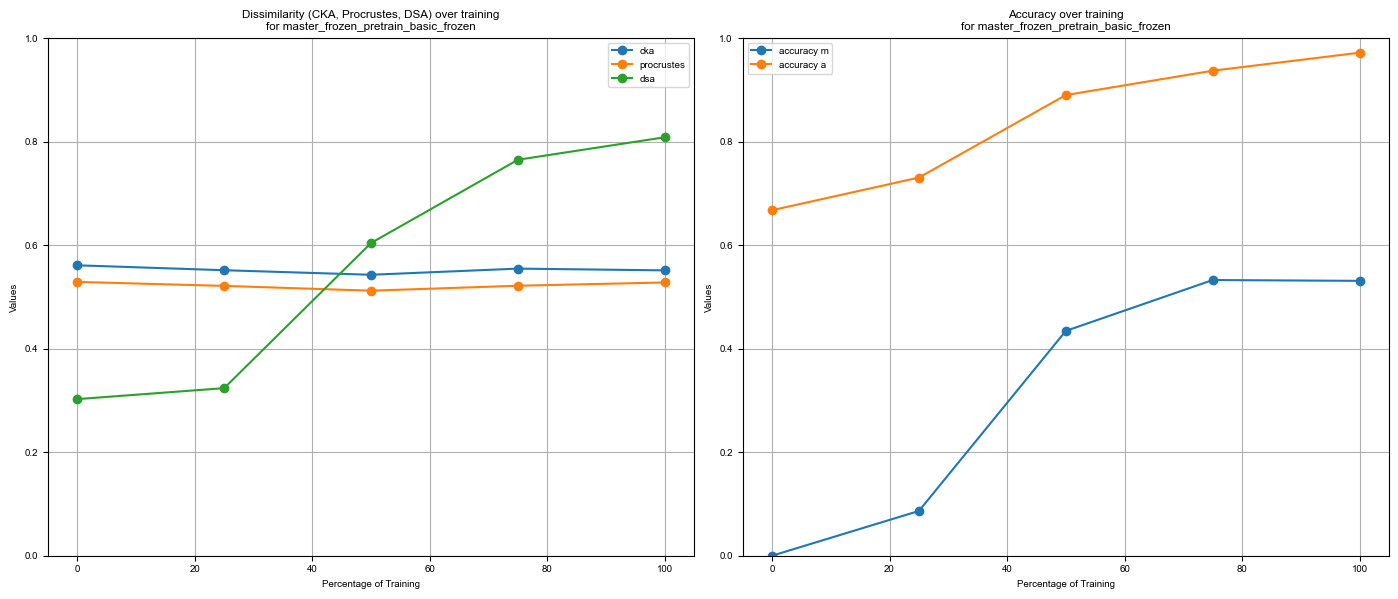

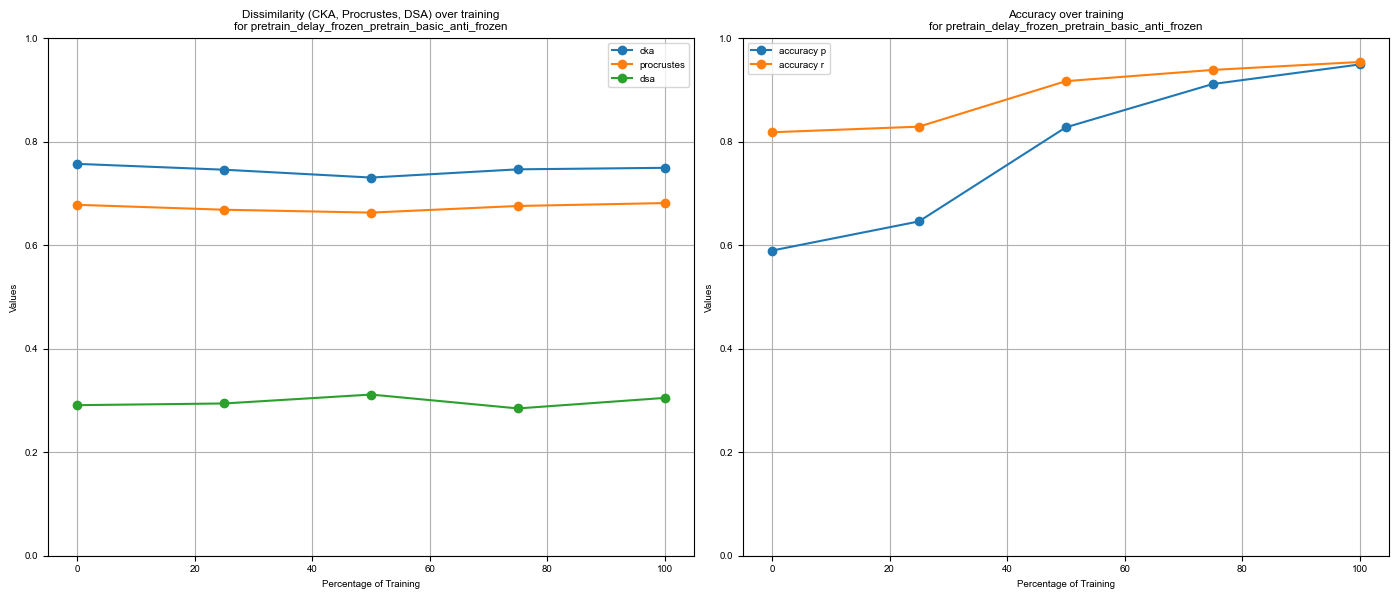

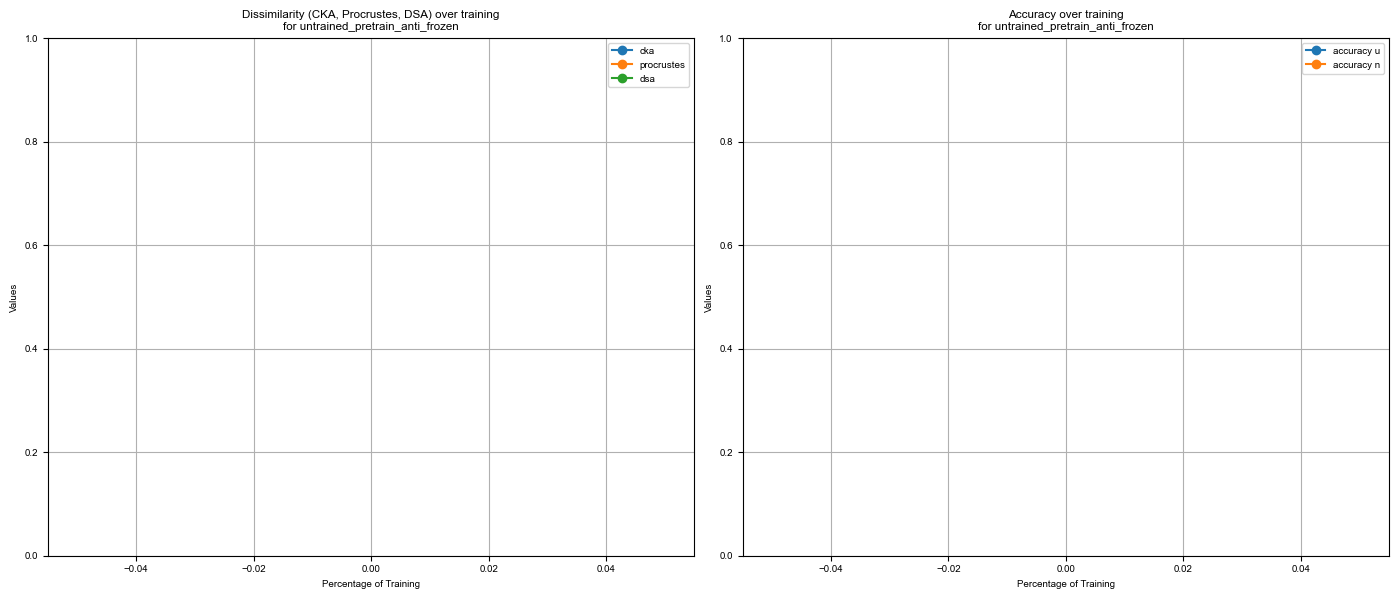

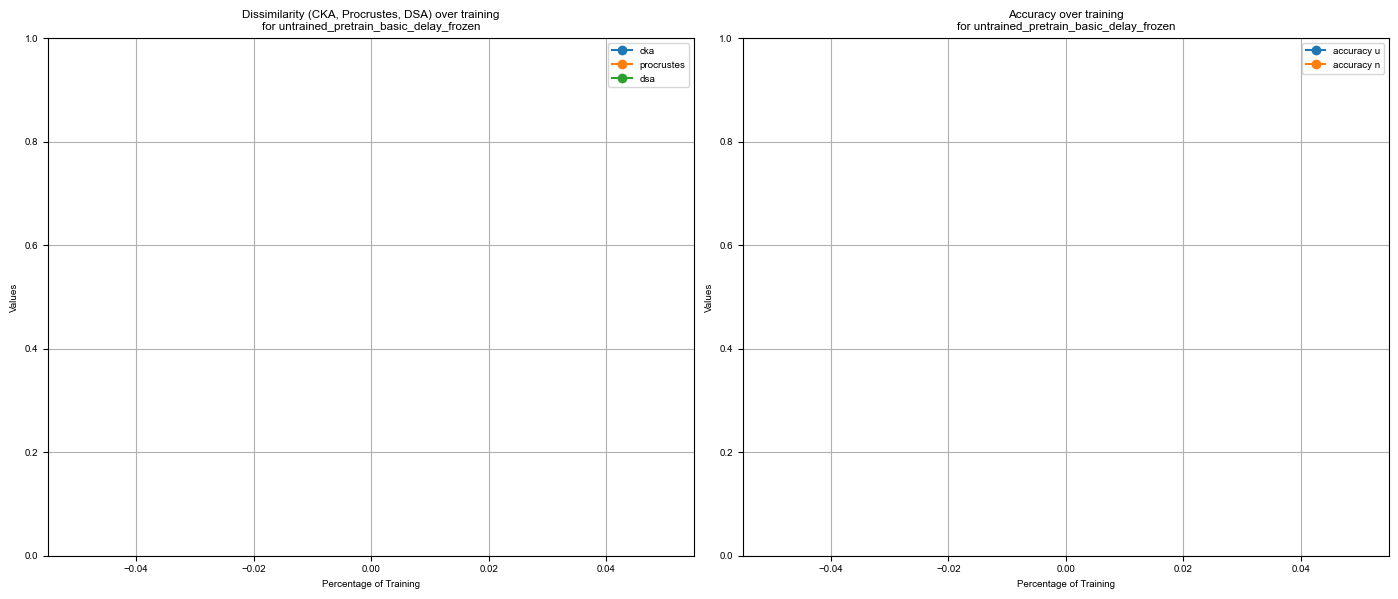

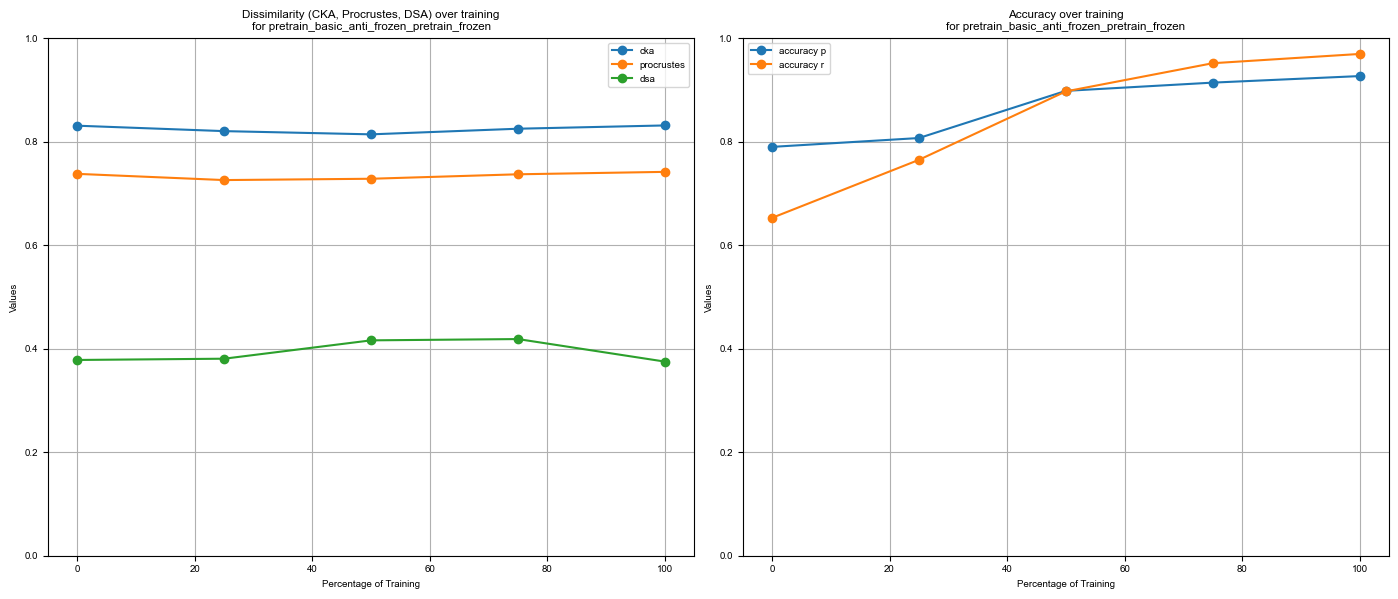

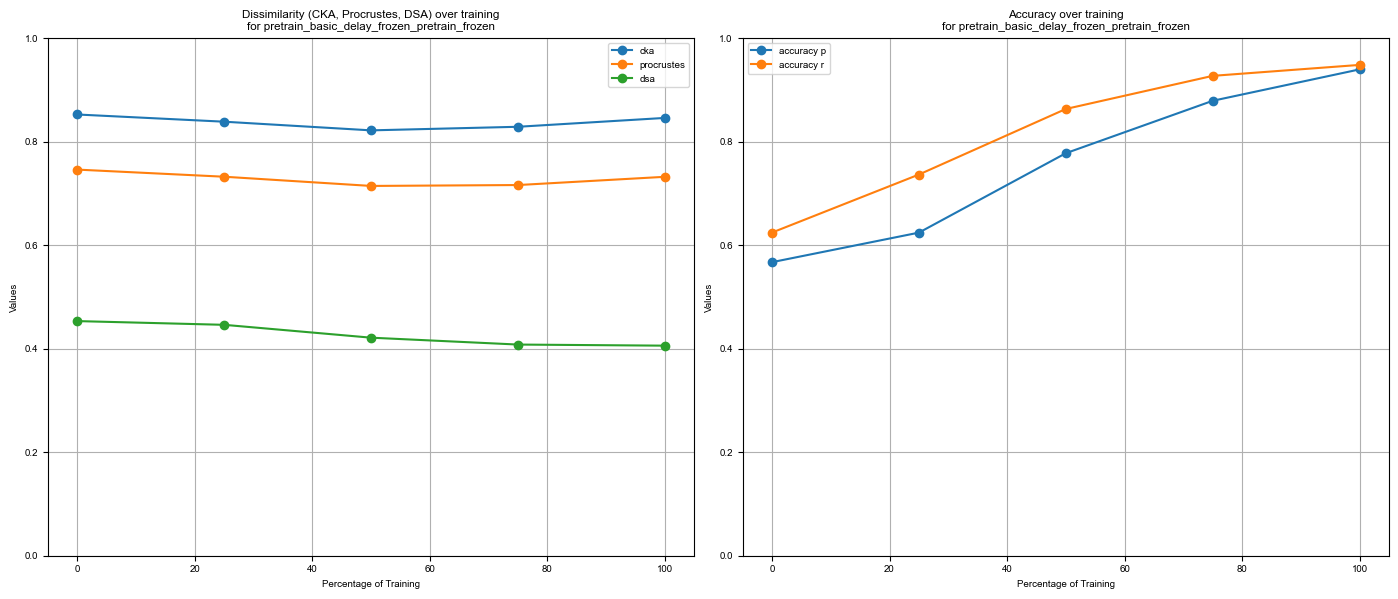

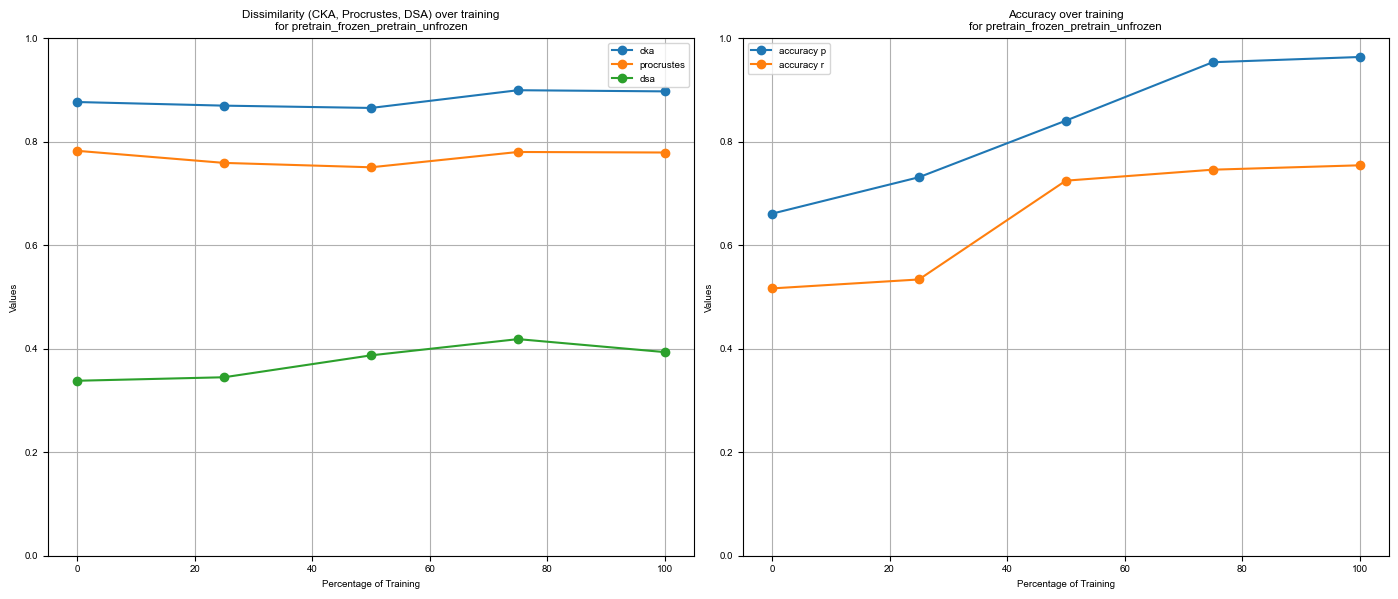

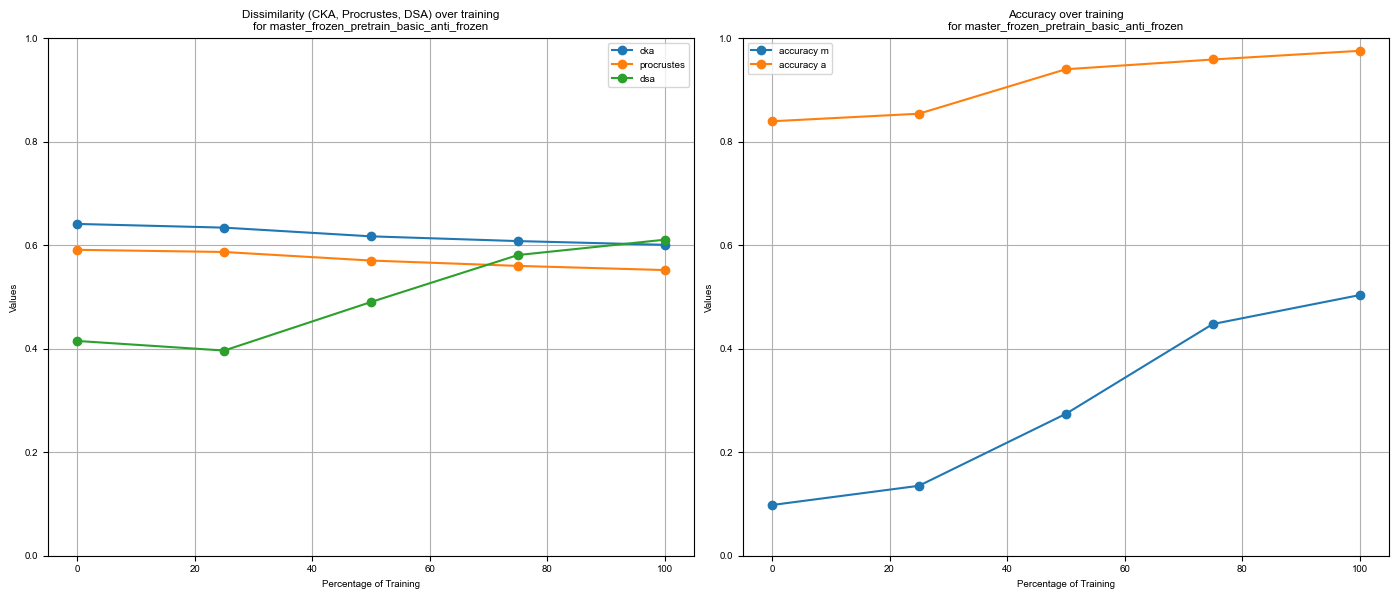

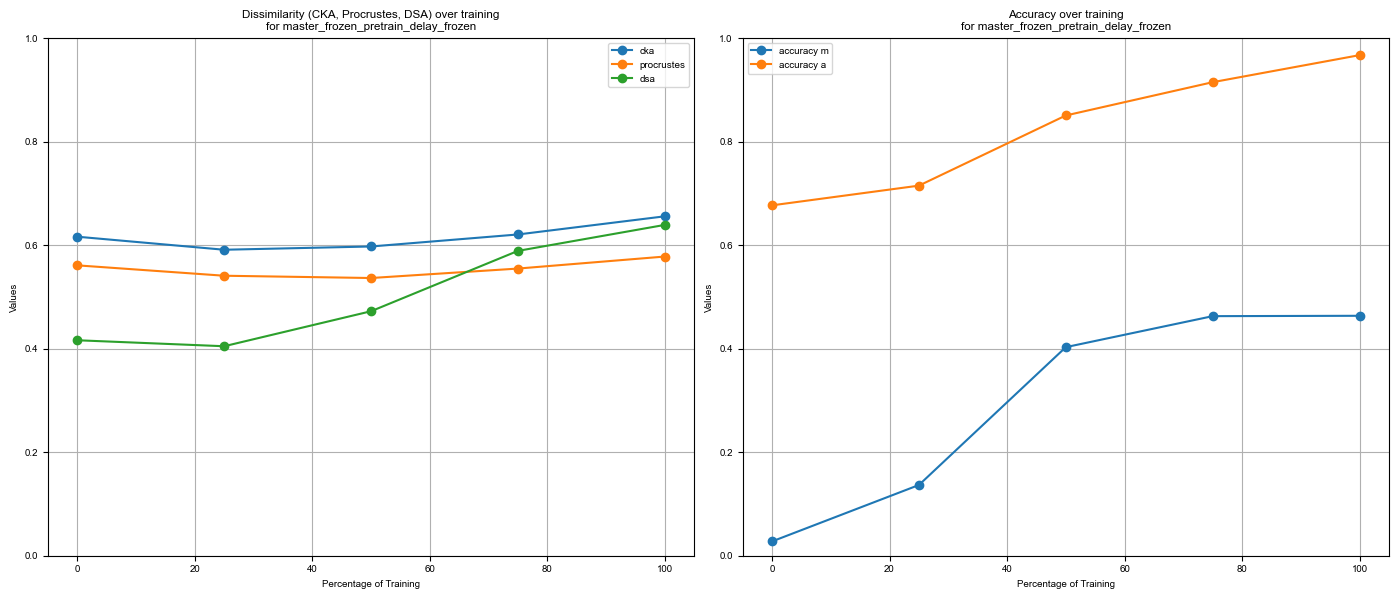

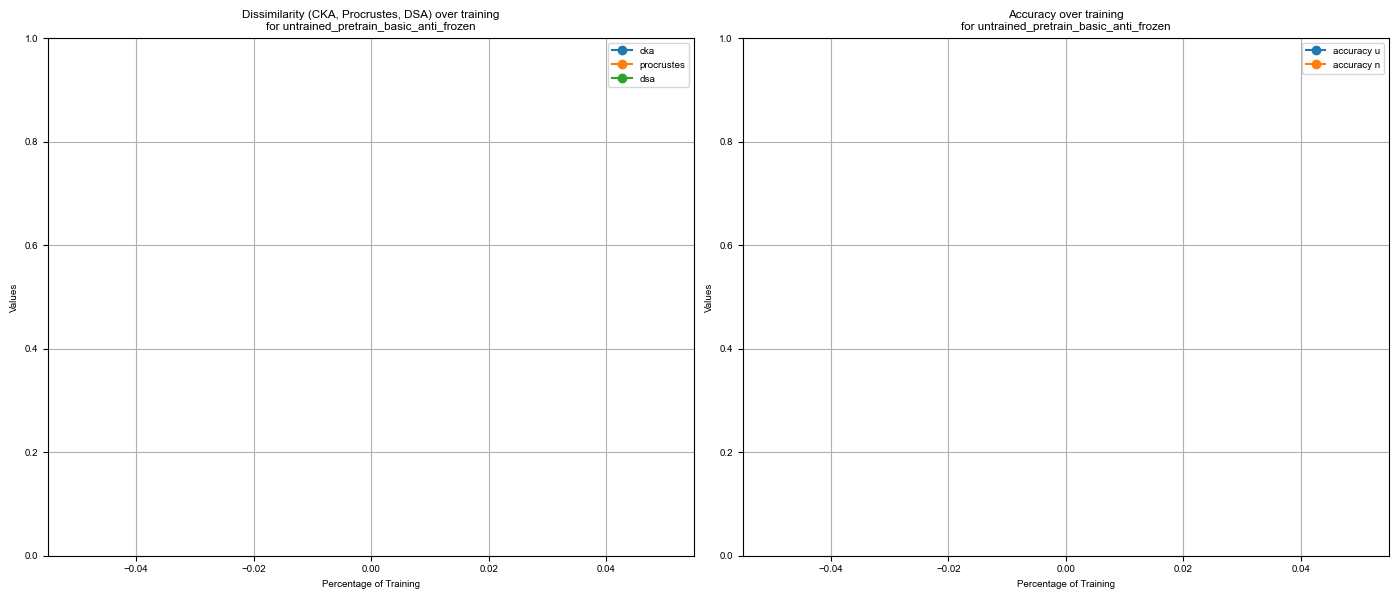

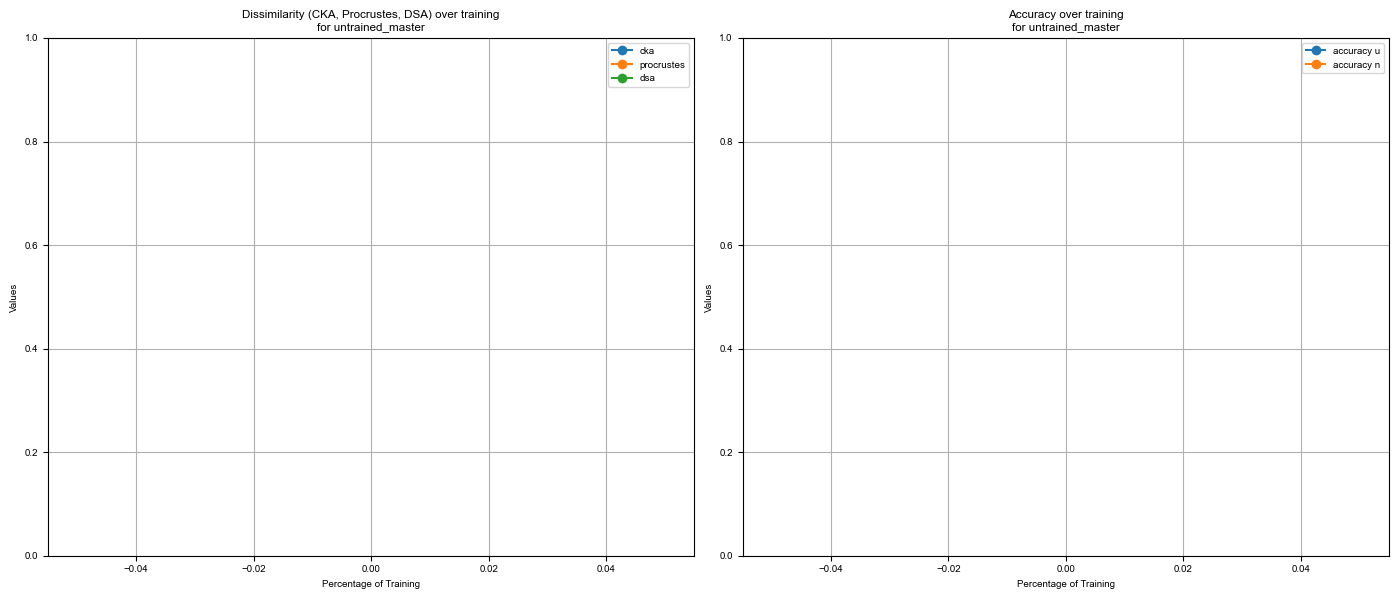

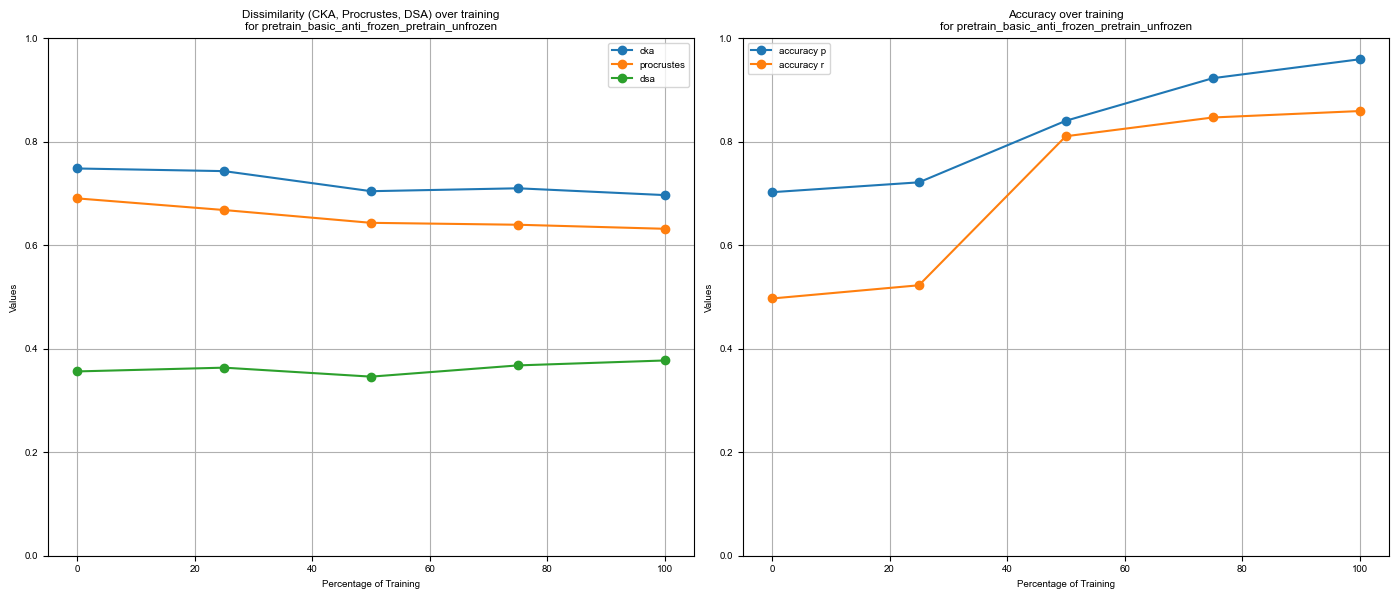

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Assuming dissimilarities_groups is defined from your previous code

# Iterate over each group in groups_training
for group_training in groups_training:
    dissimilarities_interpolated = dissimilarities_groups[group_training]

    # X-axis values
    x_values = [0, 25, 50, 75, 100]

    # Measures for the two plots
    measures_plot1 = ["cka", "procrustes", "dsa"]
    measures_plot2 = ["accuracy_1", "accuracy_2"]

    # Create the figure and the two subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

    # Plot for the first set of measures
    for key in measures_plot1:
        values = dissimilarities_interpolated[key]
        axs[0].plot(x_values, list(values.values()), marker="o", label=key)

    axs[0].set_xlabel("Percentage of Training")
    axs[0].set_ylabel("Values")
    axs[0].set_title(
        "Dissimilarity (CKA, Procrustes, DSA) over training\nfor {}".format(
            group_training
        )
    )
    axs[0].set_ylim(0, 1)
    axs[0].legend()
    axs[0].grid(True)

    # Plot for the second set of measures
    for i, key in enumerate(measures_plot2):
        values = dissimilarities_interpolated[key]
        # Rename legend label for accuracy
        label = f"accuracy {group_training[i]}"
        axs[1].plot(x_values, list(values.values()), marker="o", label=label)

    axs[1].set_xlabel("Percentage of Training")
    axs[1].set_ylabel("Values")
    axs[1].set_title("Accuracy over training\nfor {}".format(group_training))
    axs[1].set_ylim(0, 1)
    axs[1].legend()
    axs[1].grid(True)

    # Adjust layout to avoid overlapping elements
    plt.tight_layout()

    # Display the plots
    plt.show()

In [14]:
diss_cc = get_dissimilarities_shared_task_shared_curriculum(group_pairs, dissimilarities_groups, x_values)

/Users/qguilhot/Library/Mobile Documents/com~apple~CloudDocs/ETHZ/RepAL/notebooks/utils_mamba.py:250: RuntimeWarning: Mean of empty slice
  np.nanmean([diss[1][i] for diss in diss_cc[measure][shared]])


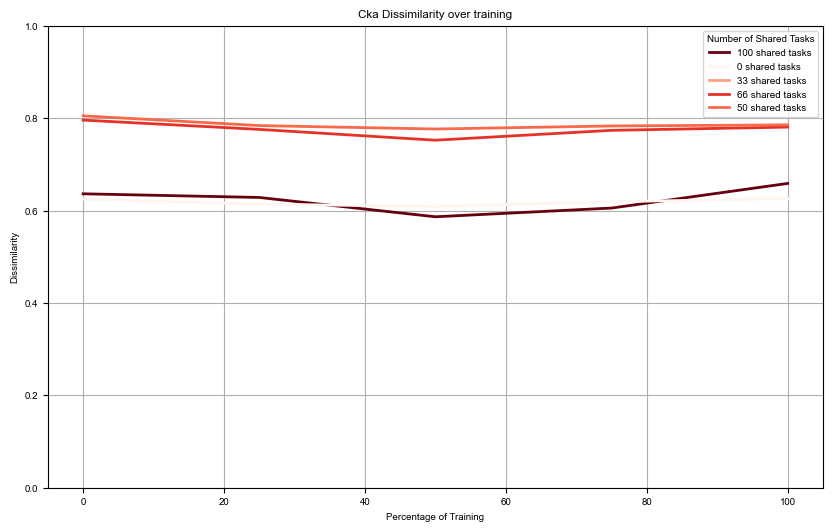

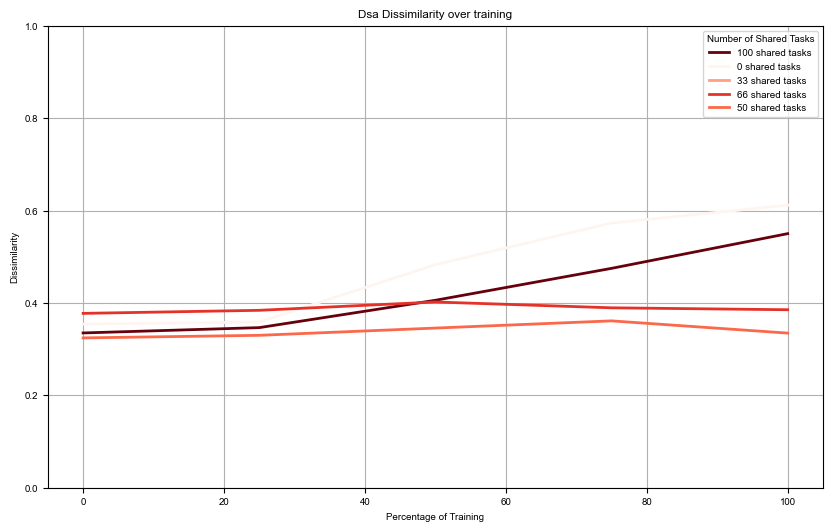

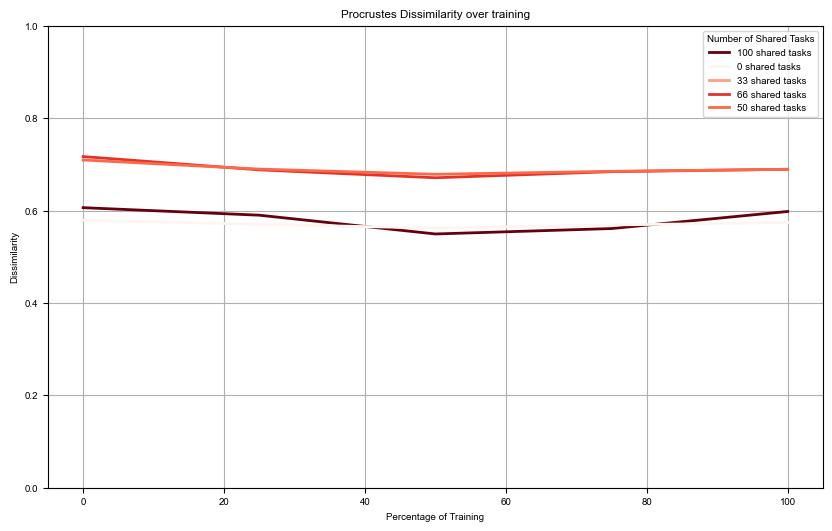

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Example data structure, assuming diss_cc is a dictionary with the following format:
# diss_cc = {
#     "cka": {
#         1: ([0, 25, 50, 75, 100], [0.9, 0.7, 0.5, 0.3, 0.1]),
#         2: ([0, 25, 50, 75, 100], [0.85, 0.65, 0.45, 0.25, 0.05]),
#         ...
#     },
#     ...
# }

# Assuming diss_cc is already defined

# Normalize the number of shared tasks to range between 0 and 1 for color mapping
all_shared_tasks = [shared for measure in diss_cc for shared in diss_cc[measure]]
min_shared = min(all_shared_tasks)
max_shared = max(all_shared_tasks)

# Create a colormap ranging from light to dark blue
cmap = cm.Reds

# Plot each measure
for measure in diss_cc:
    plt.figure(figsize=(10, 6))  # Create a new figure for each measure
    for shared in diss_cc[measure]:
        x_new, y_new = diss_cc[measure][shared]

        # Normalize shared task count to get a color
        norm_shared = (shared - min_shared) / (max_shared - min_shared)
        color = cmap(norm_shared)  # Get the color from the colormap

        plt.plot(x_new, y_new, label=f"{shared} shared tasks", color=color, linewidth=2)

    plt.xlabel("Percentage of Training")
    plt.ylim(0, 1)
    plt.ylabel("Dissimilarity")
    plt.title(f"{measure.capitalize()} Dissimilarity over training")
    plt.legend(title="Number of Shared Tasks")
    plt.grid(True)
    plt.show()

### Dissimilarity within group 

In [16]:
path = f"../data/dissimilarities_within_learning_averaged_curves_50_1/mamba/{taskset}/master"
measures = ['cka','dsa','procrustes']
dissimilarities = {measure:[] for measure in measures}


for measure in measures:
    path_measure = os.path.join(path, measure)
    files = os.listdir(path_measure)
    for file in files:
        file_path = os.path.join(path_measure, file)
        if "mamba_8" in file_path:
            if file_path.endswith(".npz"):
                with np.load(file_path) as data:
                    dissimilarities[measure].append(data["arr_0"])
# Function to check if any non-diagonal element is less than the threshold
def has_small_non_diagonal_elements(arr, threshold=1e-10):
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if i != j and arr[i, j] < threshold:
                return True
    return False
for (
    measure,
    value,
) in dissimilarities.items():  # Stack the arrays along a new axis (axis 0)
    dissimilarities[measure] = [
        arr for arr in value if not has_small_non_diagonal_elements(arr)
    ]
for (
    measure,
    value,
) in dissimilarities.items():  # Stack the arrays along a new axis (axis 0)
    dissimilarities[measure] = np.nanmedian(np.stack(value, axis=0), axis=0)

/var/folders/rg/xgkyjs4945d6ckms1nn6v0jm0000gn/T/ipykernel_2310/1070968890.py:33: RuntimeWarning: All-NaN slice encountered
  dissimilarities[measure] = np.nanmedian(np.stack(value, axis=0), axis=0)


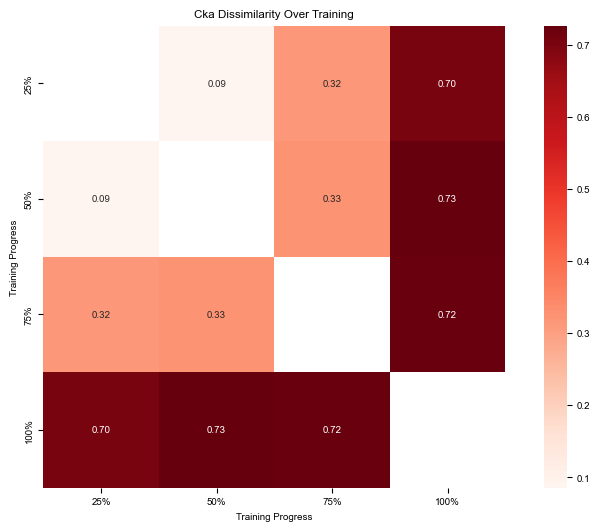

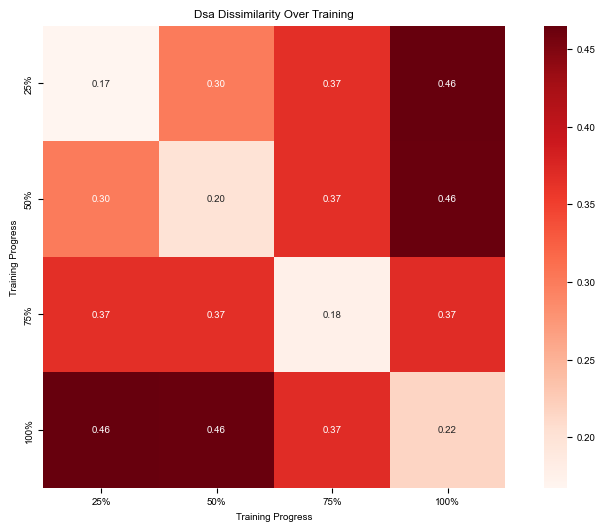

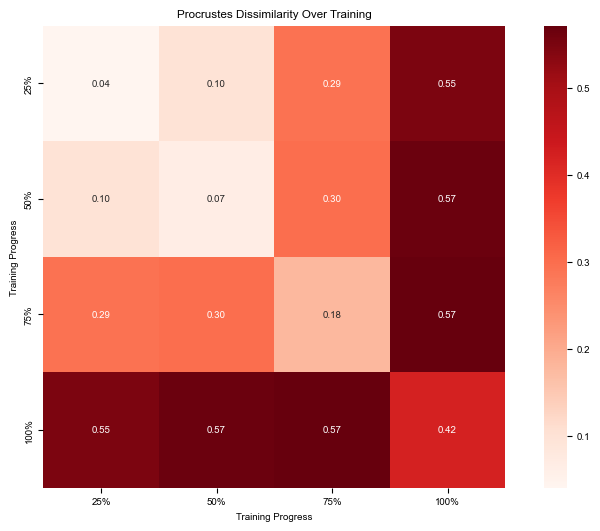

In [17]:
# Percentage labels to use instead of indices
percent_labels = ["25%", "50%", "75%", "100%"]

for measure, value in dissimilarities.items():
    # Create the heatmap
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(value, annot=True, cmap="Reds", cbar=True, square=True, fmt=".2f")

    # Set the percentage labels on the x and y axes
    ax.set_xticklabels(percent_labels)
    ax.set_yticklabels(percent_labels)

    # Set axis labels
    ax.set_xlabel("Training Progress")
    ax.set_ylabel("Training Progress")

    # Set the title
    plt.title(f"{measure.capitalize()} Dissimilarity Over Training")

    # Show the plot
    plt.show()